In [2]:
import sys, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import sklearn.metrics as skm
import sklearn.model_selection as skms
import sklearn.preprocessing as skp
import random, os
import librosa, IPython
import librosa.display as lplt
from skimage.io import imread
import os
import librosa
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
! pip install python_speech_features
from python_speech_features import mfcc
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout
from keras.models import Sequential
import os

import tensorflow as tf
import tensorflow_hub as hub

In [3]:
DIR = '/kaggle/input/audio-speech-sentiment/TRAIN/'
df = pd.read_csv('/kaggle/input/audio-speech-sentiment/TRAIN.csv')
df['Filename'] = df['Filename'] 
df.head()

,Filename,Class
0,346.wav,Negative
1,163.wav,Neutral
2,288.wav,Negative
3,279.wav,Negative
4,244.wav,Negative


In [4]:
print("Dataset has",df.shape[0],"samples")
print("Count of Positive and Negative samples")
df['Class'].value_counts().reset_index()

Dataset has 250 samples
Count of Positive and Negative samples


,index,Class
0,Negative,87
1,Positive,82
2,Neutral,81


In [5]:
!pip install python_speech_features

In [6]:
sample_rate = 44100
def loadAudio(fp):
    return librosa.load(fp, res_type='kaiser_fast', duration=2.5, offset=0.5, sr=sample_rate)

In [7]:
from tqdm import tqdm
from sklearn.preprocessing import OneHotEncoder
def voice_load(location):
    return librosa.load(location)
X = []
Y = []
for i in tqdm(df.index):
    X.append(voice_load(DIR + df.iloc[i,0]))
    Y.append(df.iloc[i,1])
X = np.array(X)
Yor = np.array(Y)
Y = Yor.reshape(Yor.shape[0],1)
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(Y)
#print(enc.categories_)
Y = enc.transform(Y).toarray()
print(X.shape,Y.shape)

100%|██████████| 250/250 [00:28<00:00,  8.72it/s]

(250, 2) (250, 3)


In [8]:
df['audio_waves'] = X[:,0]
df['samplerate'] = X[:,1]
bit_lengths = list()
for i in range(df.shape[0]):
    bit_lengths.append(len(df['audio_waves'].iloc[i]))
bit_lengths = np.array(bit_lengths)
df['bit_lengths'] = bit_lengths
df['seconds_length'] = df['bit_lengths']/df['samplerate']
df.head()

,Filename,Class,audio_waves,samplerate,bit_lengths,seconds_length
0,346.wav,Negative,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",22050,49536,2.246531
1,163.wav,Neutral,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",22050,57024,2.586122
2,288.wav,Negative,"[-0.000398024, -0.0005557723, -0.0002902077, -...",22050,37440,1.697959
3,279.wav,Negative,"[-2.5575046e-06, 3.1308904e-05, 1.6635691e-05,...",22050,52416,2.377143
4,244.wav,Negative,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",22050,51264,2.324898


In [9]:
min_bits = np.min(df['bit_lengths'])
print(min_bits)
min_seconds = np.min(df['seconds_length'])
print(min_seconds)

37440
1.6979591836734693


In [10]:
df.to_csv('AUDIO_MetaData.csv',index = False)
with open('audio_df.pickle', 'wb') as f:
    pickle.dump(df, f)
with open('audio_df.pickle', 'rb') as f:
    df = pickle.load(f)

In [11]:
df.shape

(250, 6)

In [12]:
num_samples = min(1000,df.shape[0])
generated_audio_waves = list()
generated_audio_labels = list()
for i in tqdm(range(num_samples)):
    try:
        chosen_file = np.random.choice(df['Filename'].values)
        chosen_initial = np.random.choice(np.arange(0,df[df['Filename']==chosen_file]['bit_lengths'].values-min_bits))
        generated_audio_waves.append(df[df['Filename']==chosen_file]['audio_waves'].values[0][chosen_initial:chosen_initial+min_bits])
        
        generated_audio_labels.append(df[df['Filename']==chosen_file]['Class'].values)
    except ValueError:
        continue
generated_audio_waves = np.array(generated_audio_waves)
generated_audio_labels = np.array(generated_audio_labels)

100%|██████████| 250/250 [00:00<00:00, 654.56it/s]


In [13]:
mfcc_features = list()
for i in tqdm(range(len(generated_audio_waves))):
    mfcc_features.append(mfcc(generated_audio_waves[i]))
mfcc_features = np.array(mfcc_features)

100%|██████████| 247/247 [00:01<00:00, 156.58it/s]


In [14]:
print(generated_audio_waves.shape)
print(mfcc_features.shape)

(247, 37440)
(247, 233, 13)


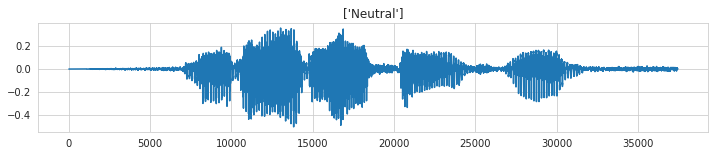

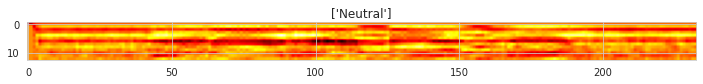

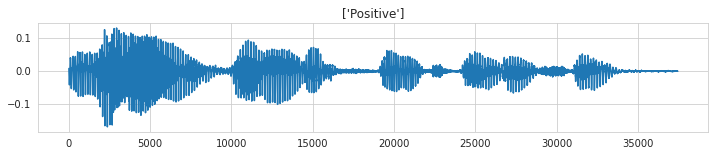

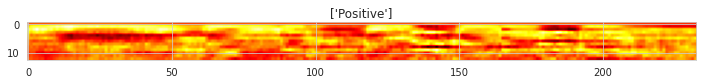

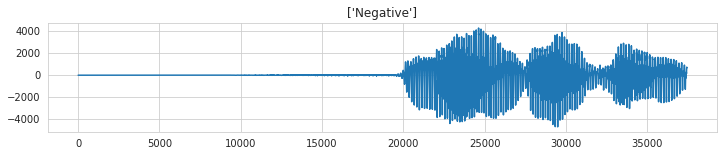

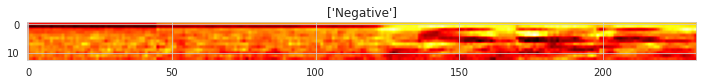

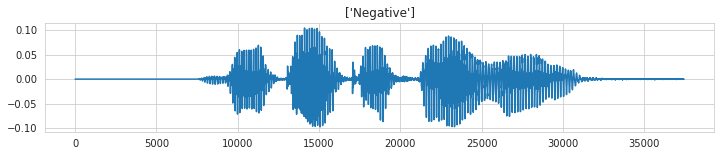

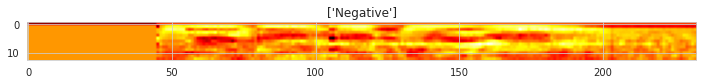

In [15]:
def plot(id):
    plt.figure(figsize=(12,2))
    plt.plot(generated_audio_waves[id])
    plt.title(generated_audio_labels[id])
    plt.show()
    plt.figure(figsize=(12, 2))
    plt.imshow(mfcc_features[id].T, cmap='hot')
    plt.title(generated_audio_labels[id])
    plt.show()
plot(30)
plot(33)
plot(43)
plot(51)

In [16]:
label_encoder = LabelEncoder()
label_encoded = label_encoder.fit_transform(generated_audio_labels)
label_encoded = label_encoded[:, np.newaxis]
one_hot_encoder = OneHotEncoder(sparse=False)
one_hot_encoded = one_hot_encoder.fit_transform(label_encoded)
import warnings
warnings.filterwarnings("ignore")
X = mfcc_features
y = one_hot_encoded
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X.shape,y.shape

((247, 233, 13), (247, 3))

# WAVE 2 VECTOR

In [17]:
X1 = X.reshape(X.shape[0], X.shape[1]*X.shape[2])
X1.shape

(247, 3029)

In [18]:
OP = np.zeros((X1.shape[0],93680))
for i in range(X1.shape[0]-1):
    OP[i,0:X1.shape[1]] = X1[i]
OP.shape

(247, 93680)

In [19]:
# audio file is decoded on the fly
# inputs = feature_extractor(
#     [d["array"] for d in dataset[:2]["audio"]], sampling_rate=sampling_rate, return_tensors="pt", padding=True
# )
# with torch.no_grad():
#     embeddings = model(**inputs).embeddings

# embeddings = torch.nn.functional.normalize(embeddings, dim=-1).cpu()

# print(inputs)
# # the resulting embeddings can be used for cosine similarity-based retrieval
# cosine_sim = torch.nn.CosineSimilarity(dim=-1)
# similarity = cosine_sim(embeddings[0], embeddings[1])
# threshold = 0.7  # the optimal threshold is dataset-dependent
# if similarity < threshold:
#     print("Speakers are not the same!")
# round(similarity.item(), 2)

In [20]:
from transformers import Wav2Vec2FeatureExtractor, Wav2Vec2ForXVector
from datasets import load_dataset
import torch
dataset = load_dataset("hf-internal-testing/librispeech_asr_demo", "clean", split="validation")
dataset = dataset.sort("id")
sampling_rate = dataset.features["audio"].sampling_rate
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained("anton-l/wav2vec2-base-superb-sv")
model = Wav2Vec2ForXVector.from_pretrained("anton-l/wav2vec2-base-superb-sv")
sampling_rate

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Dataset librispeech_asr downloaded and prepared to /root/.cache/huggingface/datasets/hf-internal-testing___librispeech_asr/clean/2.1.0/d3bc4c2bc2078fcde3ad0f0f635862e4c0fef78ba94c4a34c4c250a097af240b. Subsequent calls will reuse this data.


Downloading:   0%|          | 0.00/215 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/57.1k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/386M [00:00<?, ?B/s]

16000

In [21]:
OP.shape

(247, 93680)

In [22]:
OP[:15].shape

(15, 93680)

In [23]:
# audio file is decoded on the fly
inputs = feature_extractor(
    [d for d in OP], sampling_rate=16000, return_tensors="pt", padding=True
)
with torch.no_grad():
    embeddings = model(**inputs).embeddings

embeddings = torch.nn.functional.normalize(embeddings, dim=-1).cpu()



In [24]:
# # the resulting embeddings can be used for cosine similarity-based retrieval
# cosine_sim = torch.nn.CosineSimilarity(dim=-1)
# similarity = cosine_sim(embeddings[0], embeddings[1])
# threshold = 0.7  # the optimal threshold is dataset-dependent
# if similarity < threshold:
#     print("Speakers are not the same!")
# round(similarity.item(), 2)

In [25]:
embeddings = np.array(embeddings)

In [26]:
X_train, X_test, y_train, y_test = train_test_split(embeddings, y, test_size=0.2)
print(X_train.shape)
print(X_test.shape)

(197, 512)
(50, 512)


In [27]:
np.save('Wave2VecEmbedding.npy',embeddings)
np.save('y.npy',y)

In [28]:
import numpy as np
import pandas as pd
import os
%matplotlib inline  
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from xgboost import plot_tree
from xgboost import plot_importance
import numpy as np
import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from collections import Counter
import cv2
import os
import glob
import skimage
import numpy as np
import pandas as pd
import seaborn as sn
import preprocessing
from tqdm import tqdm
from PIL import Image
from os import listdir
import matplotlib.pyplot as plt
from skimage.transform import resize
from collections import Counter
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import AUC
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications.vgg16 import VGG16 # VGG16
from tensorflow.keras.applications.vgg19 import VGG19 # VGG19
from tensorflow.keras.applications.resnet50 import ResNet50 # ResNet50
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.applications.xception import Xception # Xception
from tensorflow.keras.applications.mobilenet import MobileNet # MobileNet
from tensorflow.keras.applications.nasnet import NASNetMobile # NASNetMobile
from tensorflow.keras.applications.densenet import DenseNet169 # DenseNet169
from tensorflow.keras.applications.densenet import DenseNet121 # DenseNet121
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2 # MobileNetV2
from tensorflow.keras.applications.inception_v3 import InceptionV3 # InceptionV3
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Flatten, Activation, GlobalAveragePooling2D,Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score,classification_report
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import  metrics
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import AUC
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications.vgg16 import VGG16 # VGG16
from tensorflow.keras.applications.vgg19 import VGG19 # Inception
from tensorflow.keras.applications.resnet50 import ResNet50 # ResNet50
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.applications.xception import Xception # Xception
from tensorflow.keras.applications.mobilenet import MobileNet # MobileNet
from tensorflow.keras.applications.nasnet import NASNetMobile # NASNetMobile
from tensorflow.keras.applications.densenet import DenseNet169 # DenseNet169
from tensorflow.keras.applications.densenet import DenseNet121 # DenseNet121
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2 # MobileNetV2
from tensorflow.keras.applications.inception_v3 import InceptionV3 # InceptionV3
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Flatten, Activation, GlobalAveragePooling2D,Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import xgboost as xgb
from sklearn.ensemble import *
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import *
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn import model_selection
from sklearn.metrics import accuracy_score, log_loss
import sklearn
import string
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import roc_curve, auc, roc_auc_score,accuracy_score,confusion_matrix
import warnings
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score,classification_report
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import  metrics
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix
import seaborn as sns
warnings.filterwarnings("ignore")

In [29]:
def multiclass_roc_auc_score(y_test, y_pred, name,  average="macro"):
    fig, c_ax = plt.subplots(1,1, figsize = (30, 30))
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)
    target= list(np.unique(le.classes_))
    matplotlib.rcParams.update({'font.size': 12})
    for (idx, c_label) in enumerate(target):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
    c_ax.legend()
    c_ax.set_xlabel('False Positive Rate',fontsize = 26)
    c_ax.set_ylabel('True Positive Rate',fontsize = 26)
    
    plt.savefig('ROC_AUC__'+name+'.jpeg')
    plt.show()
    return roc_auc_score(y_test, y_pred, average=average)
def onevsall(y_true,y_pred,mod):
    df = pd.DataFrame()
    lb = LabelBinarizer()
    lb.fit(y_true)
    y_test = lb.transform(y_true)
    y_pred = lb.transform(y_pred)
    target= list(np.unique(le.classes_))
    df = pd.DataFrame()
    ACC = 0
    PRE = 0
    REC = 0
    F1 = 0
    SP = 0
    for (idx, c_label) in enumerate(target):
        tn, fp, fn, tp = confusion_matrix(y_test[:,idx].astype(int), y_pred[:,idx]).ravel()
        acc = (tp+tn)/(tp+tn+fp+fn)
        ACC += acc
        pre = tp/(tp+fp)
        PRE += pre
        rec = tp/(tp+fn)
        REC += rec
        f1 = 2*rec*pre / (rec +pre)
        F1 += f1
        sp = tn / (tn +fp)
        SP += sp
        df=df.append({
            'Class':c_label,
            'TN':tn,'FP':fp,'FN':fn,'TP':tp,
            'Accuracy':acc,
            'Precision':pre,
            'Recall or Sensitivity':rec,
            'F1 Score':f1,
            'Specificity':sp
        },ignore_index=True)
    df.to_csv(mod+'.csv')
    global rdf
    rdf=rdf.append({
            'Model':mod,
            'TN':tn,'FP':fp,'FN':fn,'TP':tp,
            'Accuracy':ACC / len(target),
            'Precision':PRE / len(target),
            'Recall or Sensitivity':REC / len(target),
            'F1 Score':F1 / len(target),
            'Specificity':SP / len(target)
        },ignore_index=True)
    return rdf
def run(clf,X_train, y_train,X_test,y_test):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_true = y_test
    name = np.unique(y_train)
    return visualise(y_true,y_pred,name,clf.__class__.__name__),clf
def RNDF(X_train, y_train,sel_x,y):
    for clf in tqdm(models_f1):
        print(clf.__class__.__name__)
        run(clf,X_train, y_train,sel_x,y)
    return rdf
def visualise(y_true,y_pred,name  ,model_name):
    print(np.unique(y_true), np.unique(y_pred))
    ConfusionM = confusion_matrix(y_true,y_pred)

    print('ROC AUC score:', 
    multiclass_roc_auc_score(y_true,y_pred,model_name ))
    print(classification_report(y_true,y_pred,   digits=4))
    print()
    fig, ax = plt.subplots(figsize=(30,30)) 
    import seaborn as sns
    sns.heatmap(ConfusionM, annot=True,
            fmt='g',xticklabels=list(np.unique(le.classes_)), yticklabels=list(np.unique(le.classes_)))
    plt.title('Confusion Matrix for '+model_name)
    plt.savefig('CM_'+model_name+'.jpg')
    plt.show()
    return onevsall(y_true,y_pred,model_name)
import xgboost as xgb
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
models_f1 = []
#models_f1.append(HistGradientBoostingClassifier(max_iter=10))
models_f1.append((RandomForestClassifier(n_estimators=12, criterion='gini', max_depth=None, 
                                         min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, 
                                         max_features='sqrt', max_leaf_nodes=None, min_impurity_decrease=0.0, 
                                         bootstrap=True, oob_score=False, n_jobs=None, random_state=None, 
                                         verbose=0, warm_start=False, class_weight=None)))
models_f1.append((DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=None, 
                                         min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0,
                                         max_features=None, random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, 
                                         class_weight=None, ccp_alpha=0.0)))


models_f1.append(VotingClassifier(estimators=[
 ('lr', LogisticRegression(multi_class='multinomial', random_state=1)), 
    ('rf', RandomForestClassifier(n_estimators=12, random_state=1)),
    ('gnb', SVC())], voting='hard')
                )



models_f1.append((AdaBoostClassifier( n_estimators=5, 
                                     learning_rate=1.0)))
models_f1.append(xgb.XGBClassifier(max_depth= 2, n_estimators=5))


from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib

models_f1

[RandomForestClassifier(max_features='sqrt', n_estimators=12),
 DecisionTreeClassifier(),
 VotingClassifier(estimators=[('lr',
                               LogisticRegression(multi_class='multinomial',
                                                  random_state=1)),
                              ('rf',
                               RandomForestClassifier(n_estimators=12,
                                                      random_state=1)),
                              ('gnb', SVC())]),
 AdaBoostClassifier(n_estimators=5),
 XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, gamma=None,
               gpu_id=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=None, max_bin=None,
               max_cat_to_onehot=None, max_delta_step=N

In [30]:
np.unique(y)


array([0., 1.])

In [31]:
yml = list(y)
yml = [str(item) for item in yml]




In [32]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(yml)
yml = le.transform(yml)
num_classes=  len(le.classes_)
num_classes

3

In [33]:
np.save('MLclasses.npy',yml)

  0%|          | 0/5 [00:00<?, ?it/s]

RandomForestClassifier
[0 1 2] [0 1 2]


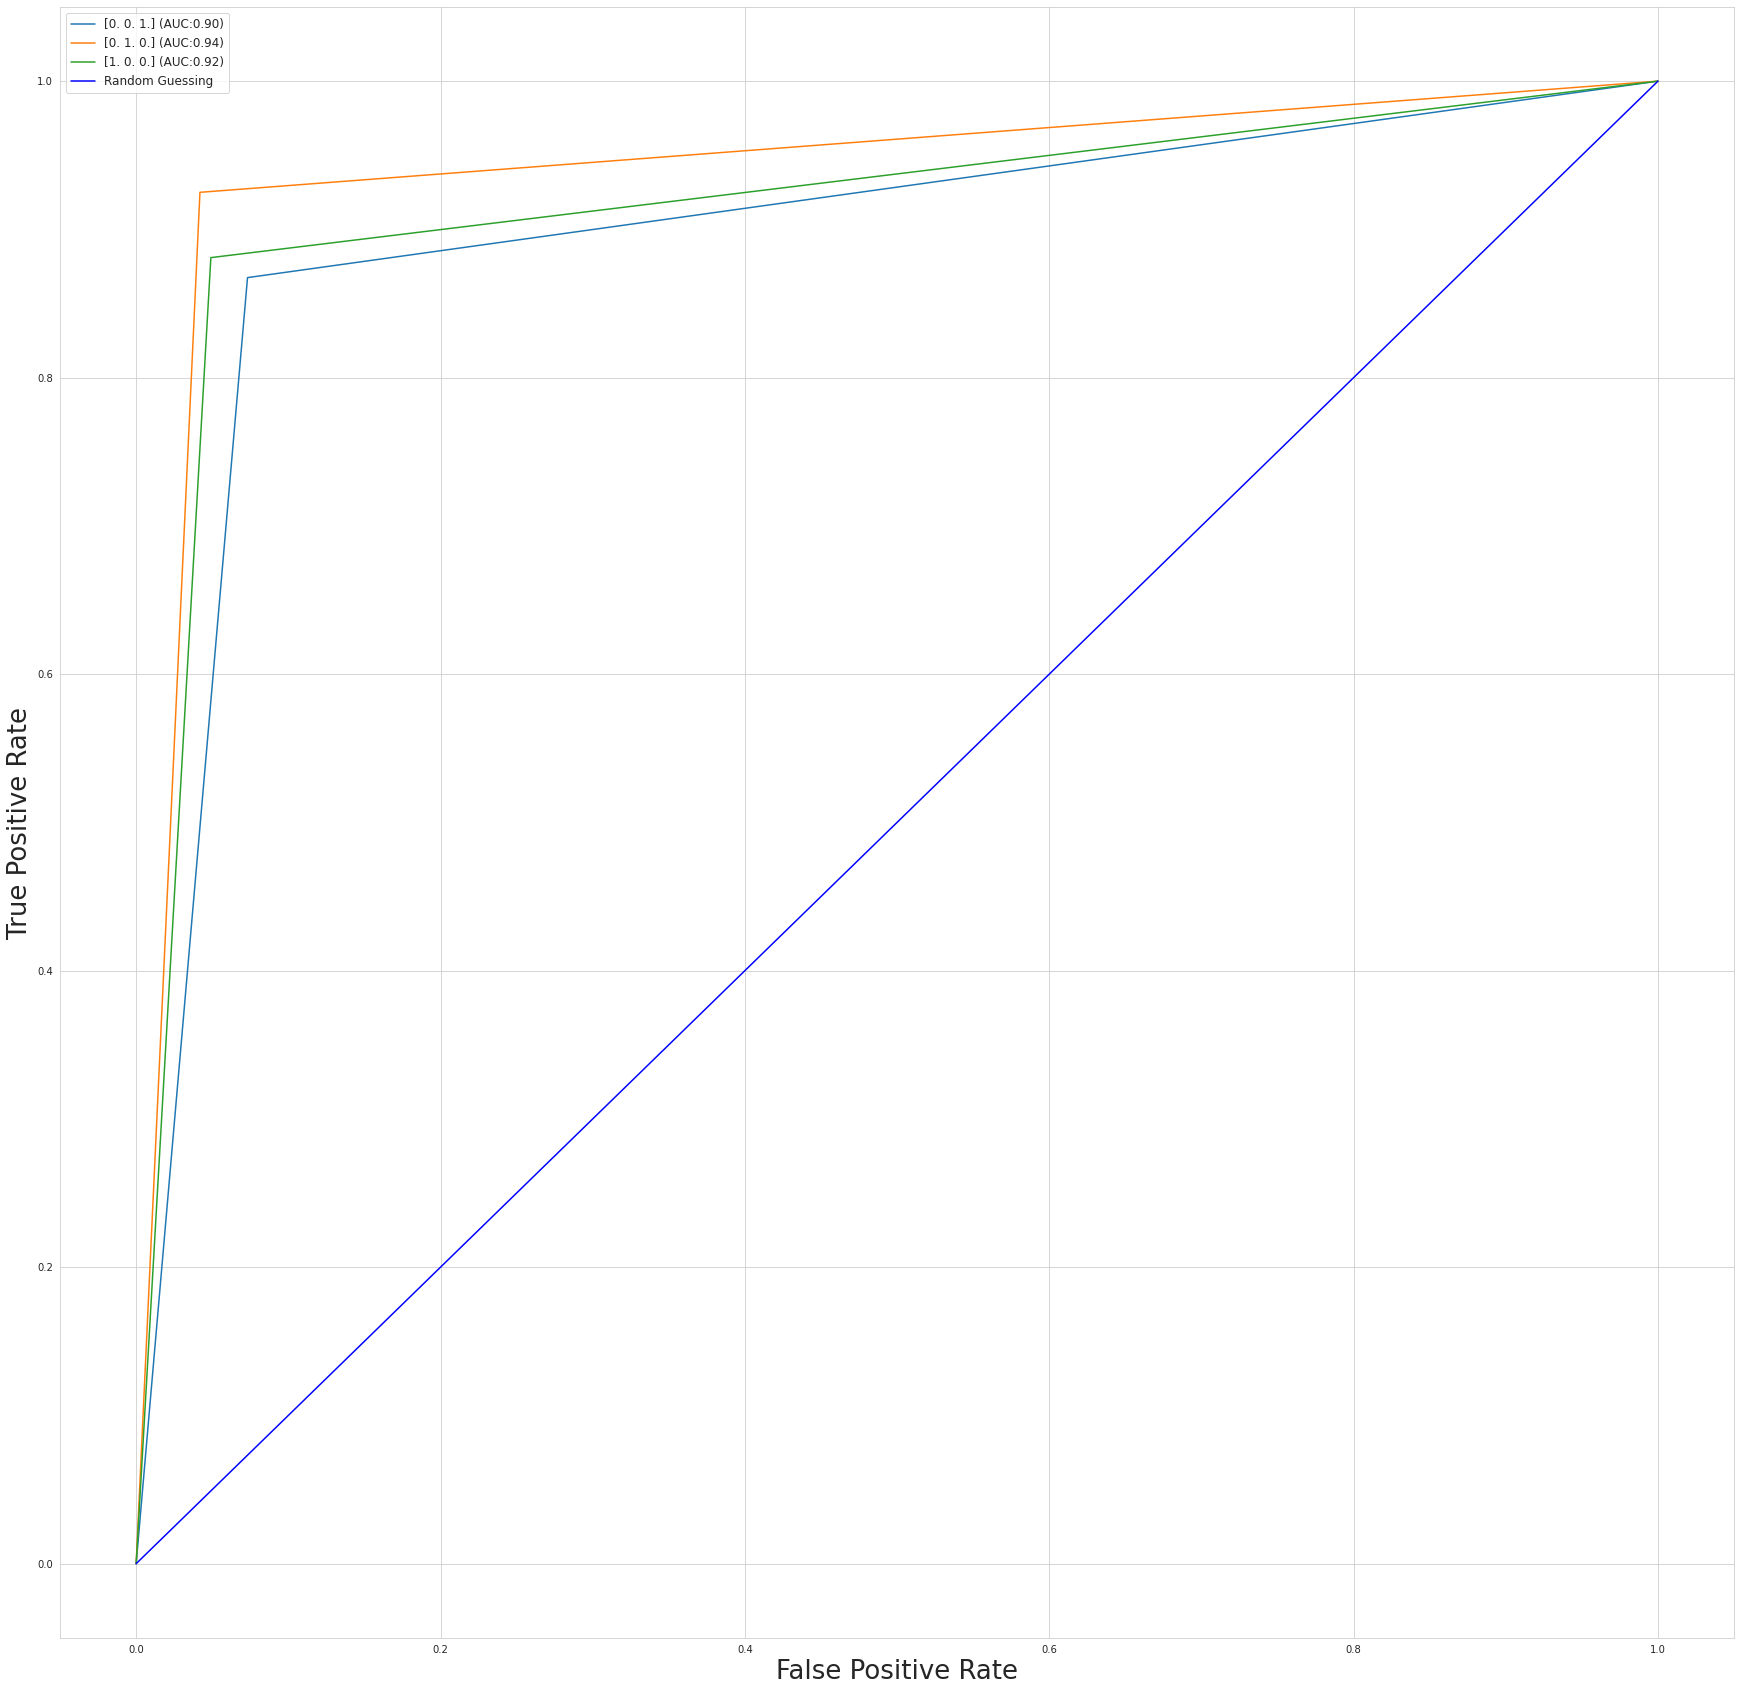

ROC AUC score: 0.9182092677495398
              precision    recall  f1-score   support

           0     0.8571    0.8675    0.8623        83
           1     0.9136    0.9250    0.9193        80
           2     0.9024    0.8810    0.8916        84

    accuracy                         0.8907       247
   macro avg     0.8911    0.8911    0.8910       247
weighted avg     0.8908    0.8907    0.8907       247




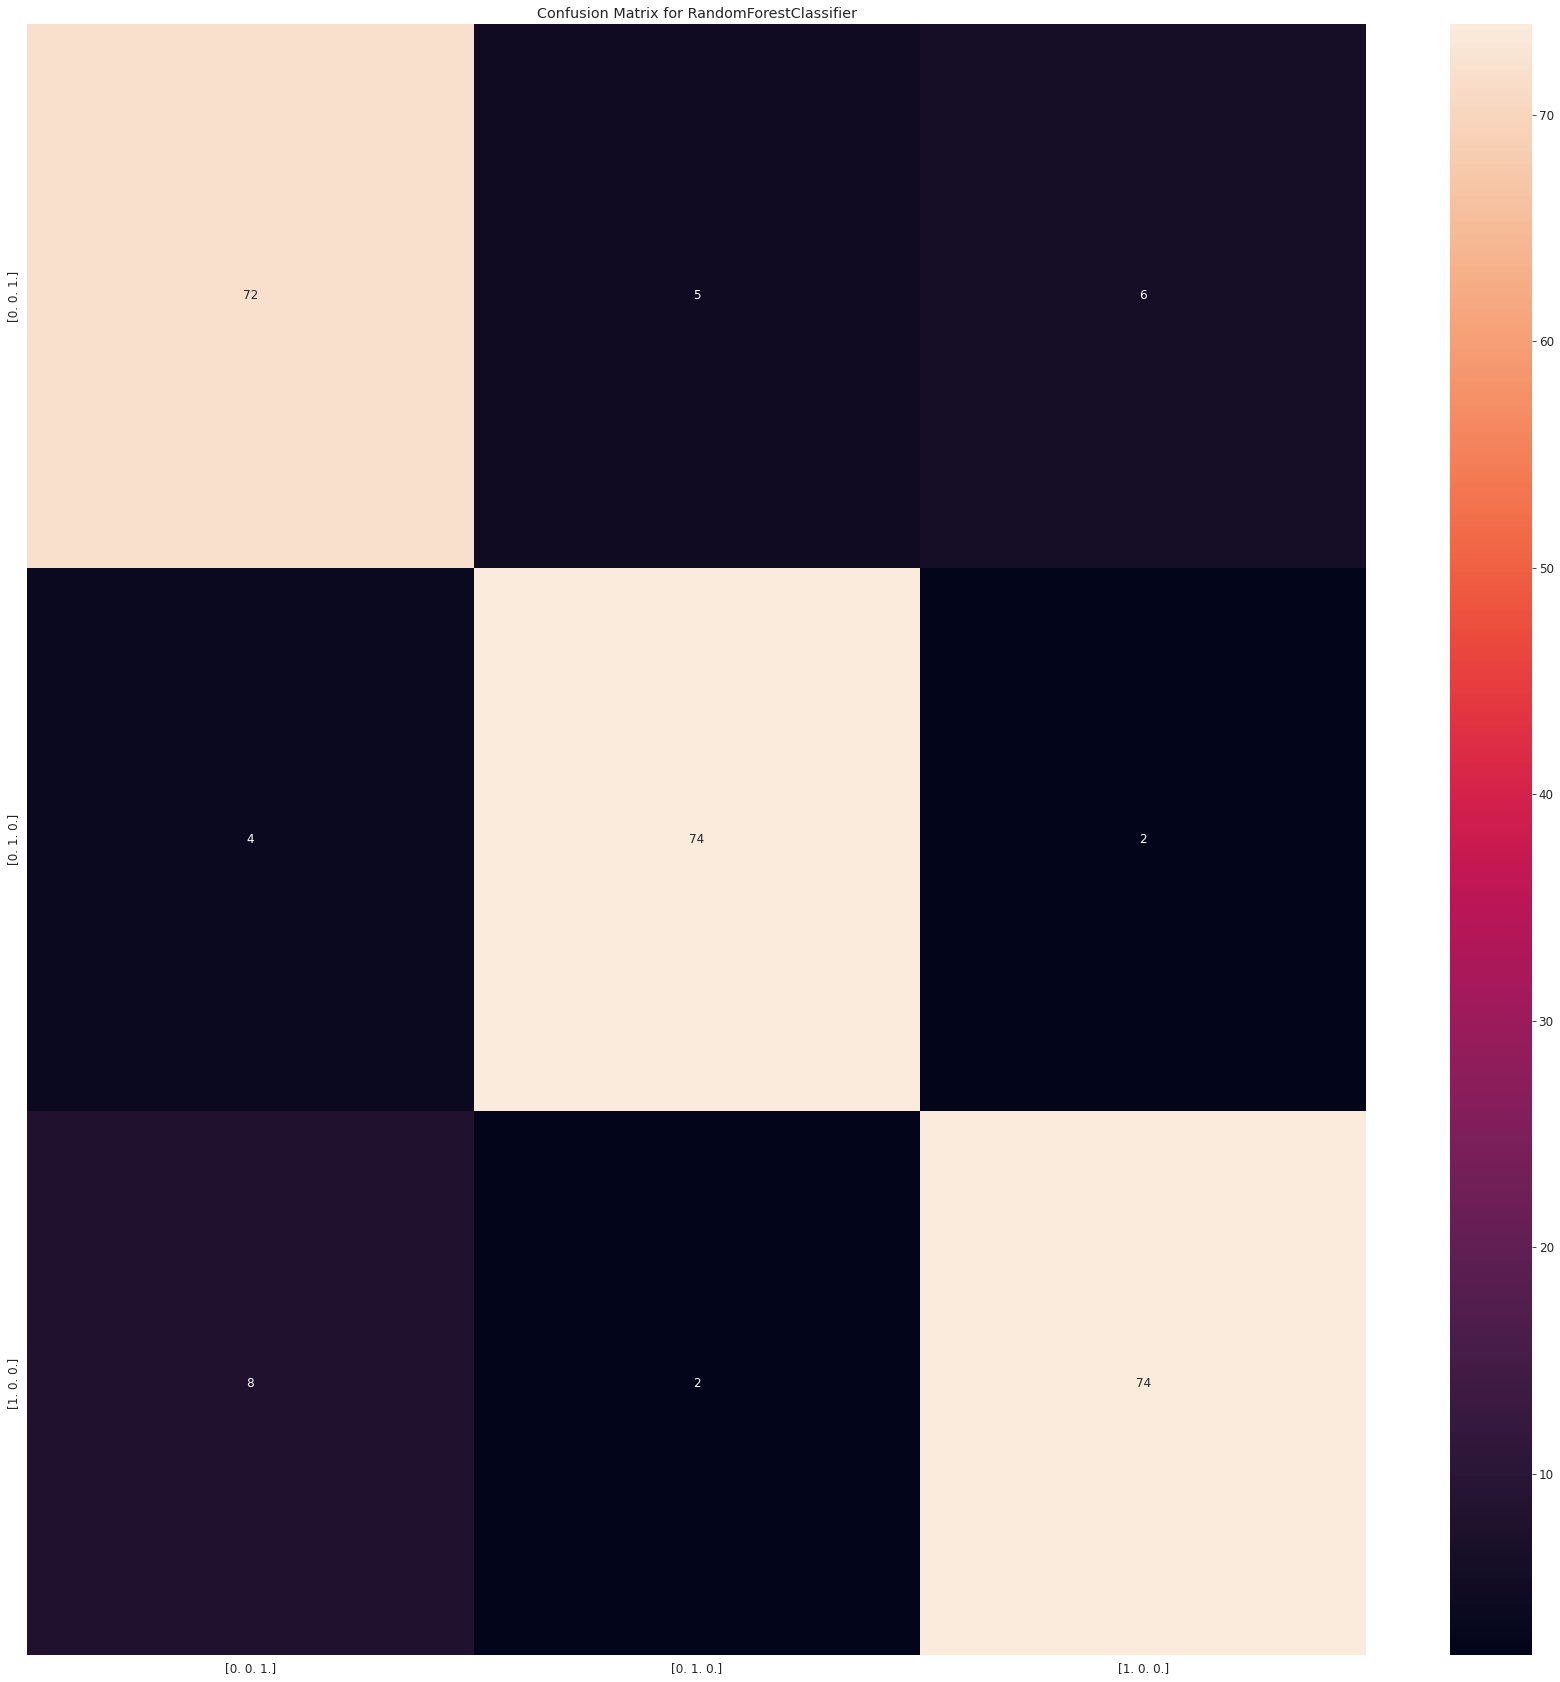

 20%|██        | 1/5 [00:01<00:06,  1.53s/it]

DecisionTreeClassifier
[0 1 2] [0 1 2]


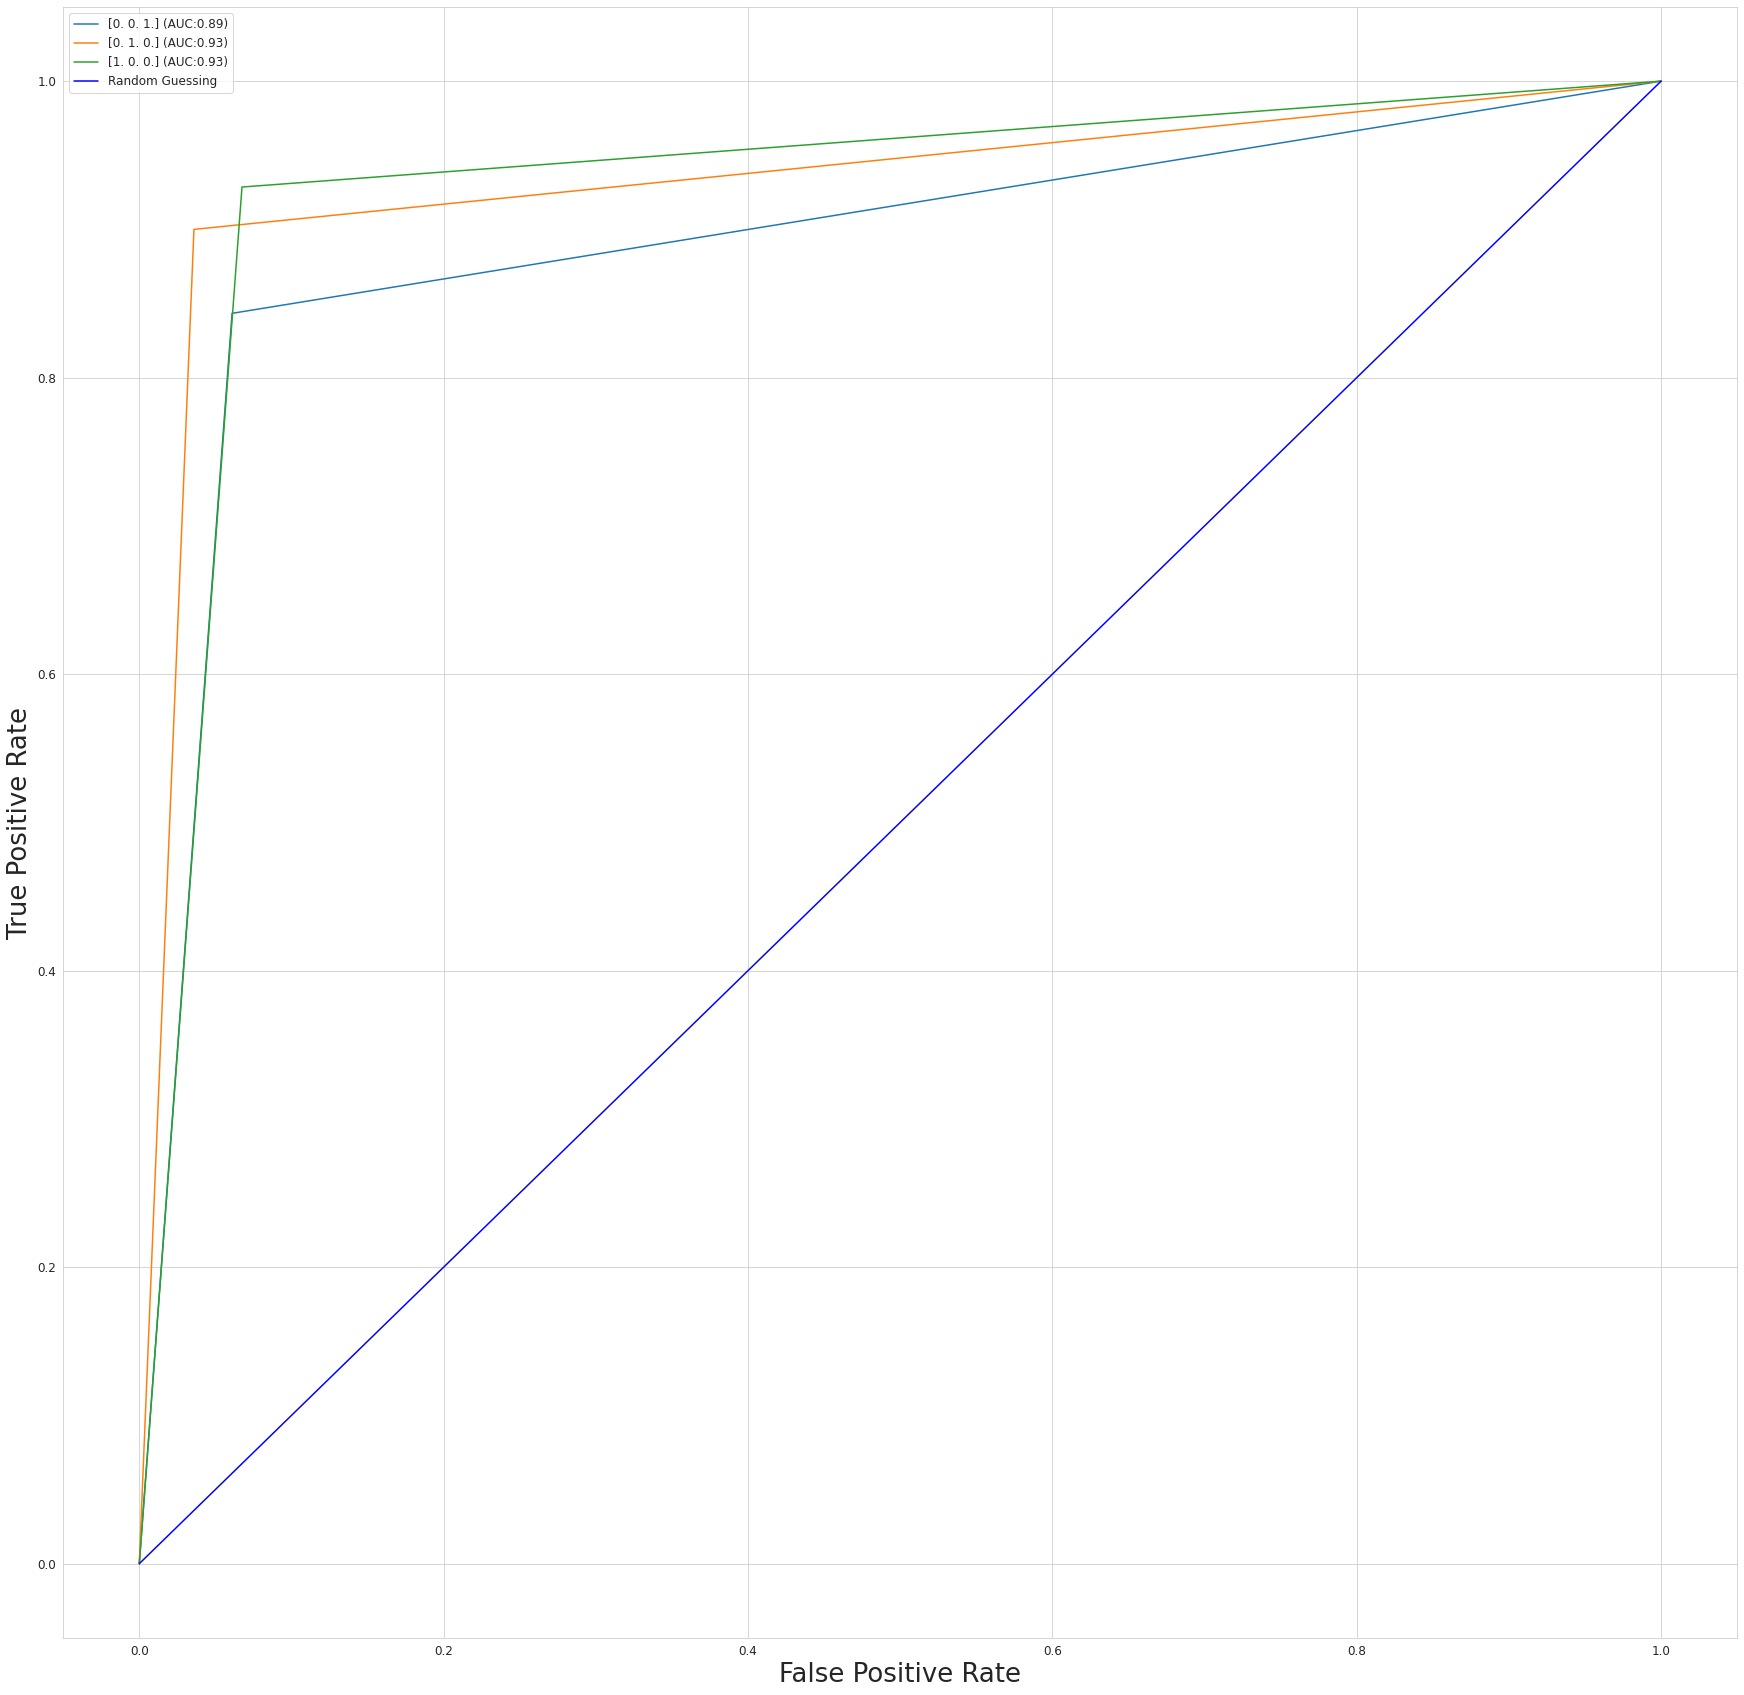

ROC AUC score: 0.9179260844169955
              precision    recall  f1-score   support

           0     0.8750    0.8434    0.8589        83
           1     0.9231    0.9000    0.9114        80
           2     0.8764    0.9286    0.9017        84

    accuracy                         0.8907       247
   macro avg     0.8915    0.8906    0.8907       247
weighted avg     0.8910    0.8907    0.8905       247




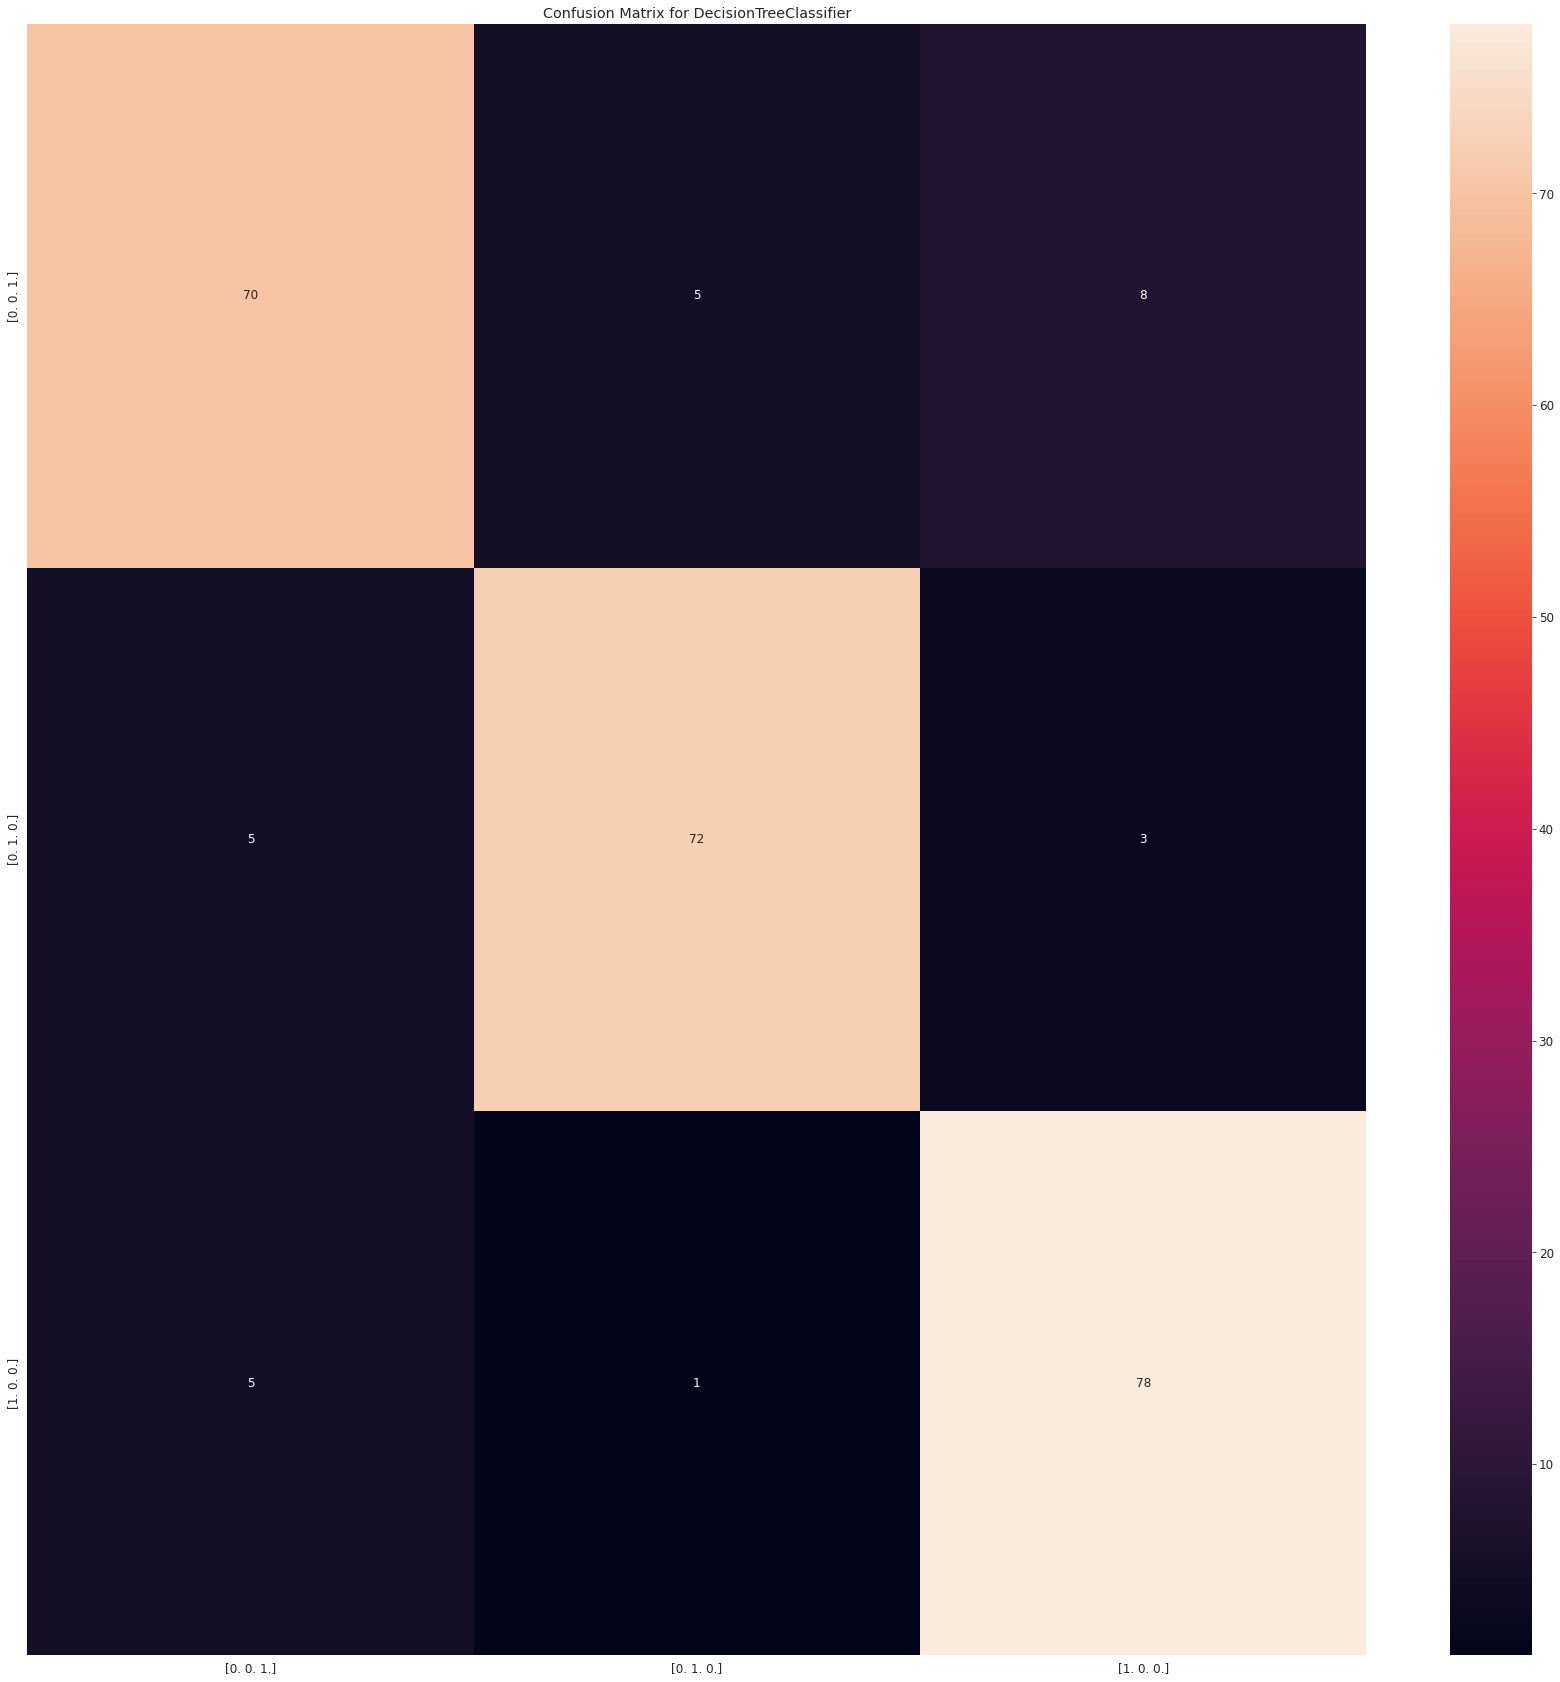

 40%|████      | 2/5 [00:03<00:04,  1.54s/it]

VotingClassifier
[0 1 2] [0 1 2]


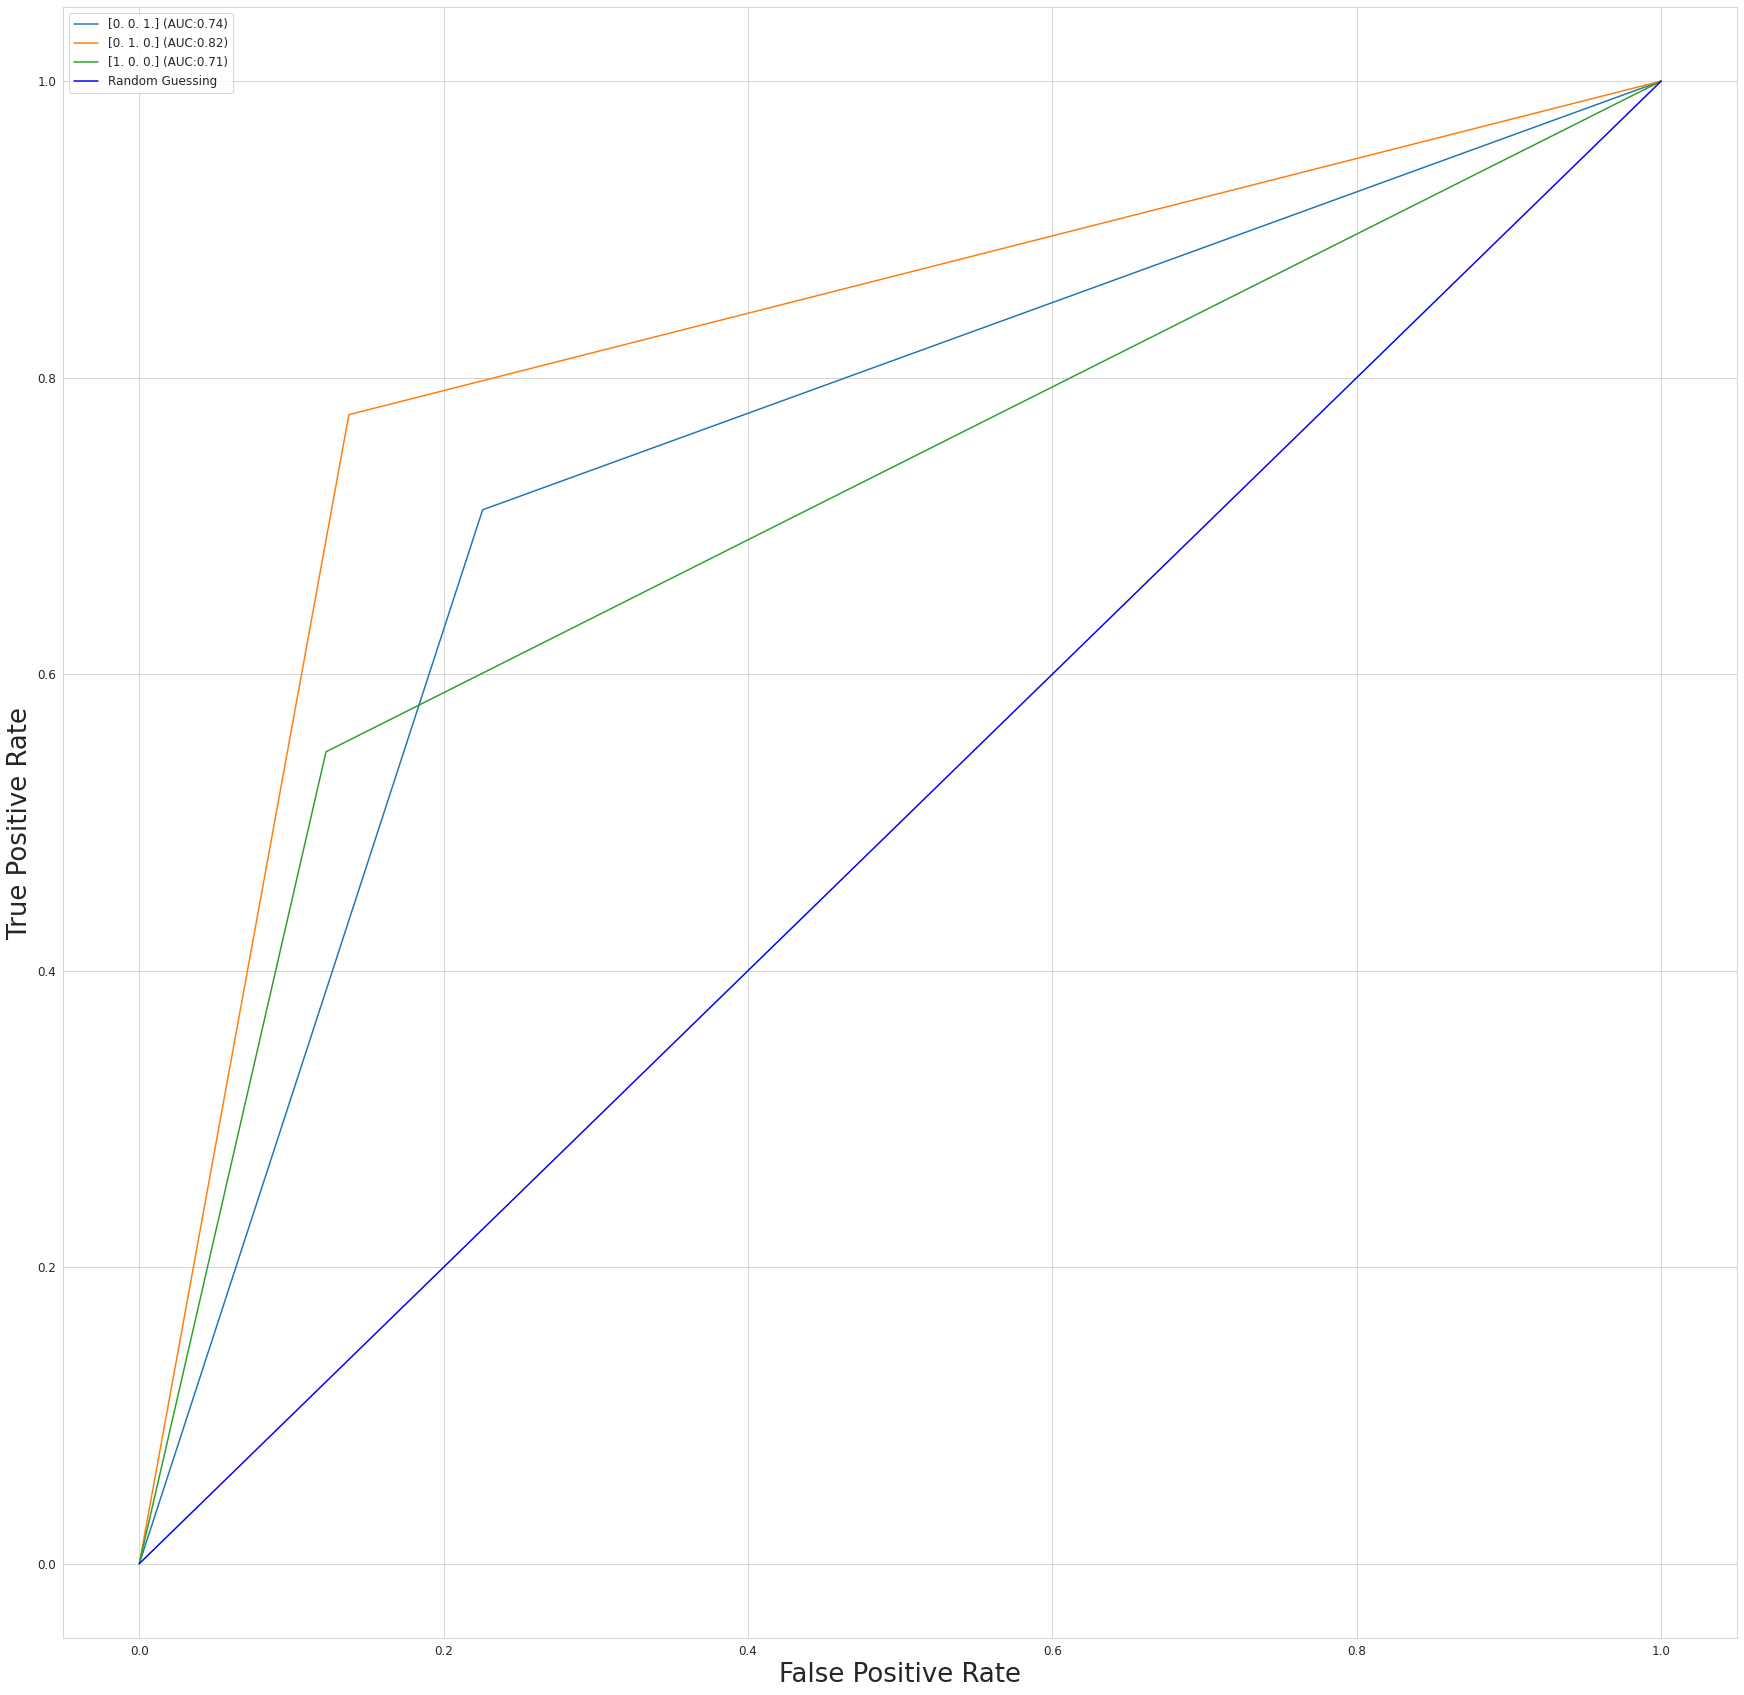

ROC AUC score: 0.7579047879356985
              precision    recall  f1-score   support

           0     0.6146    0.7108    0.6592        83
           1     0.7294    0.7750    0.7515        80
           2     0.6970    0.5476    0.6133        84

    accuracy                         0.6761       247
   macro avg     0.6803    0.6778    0.6747       247
weighted avg     0.6798    0.6761    0.6735       247




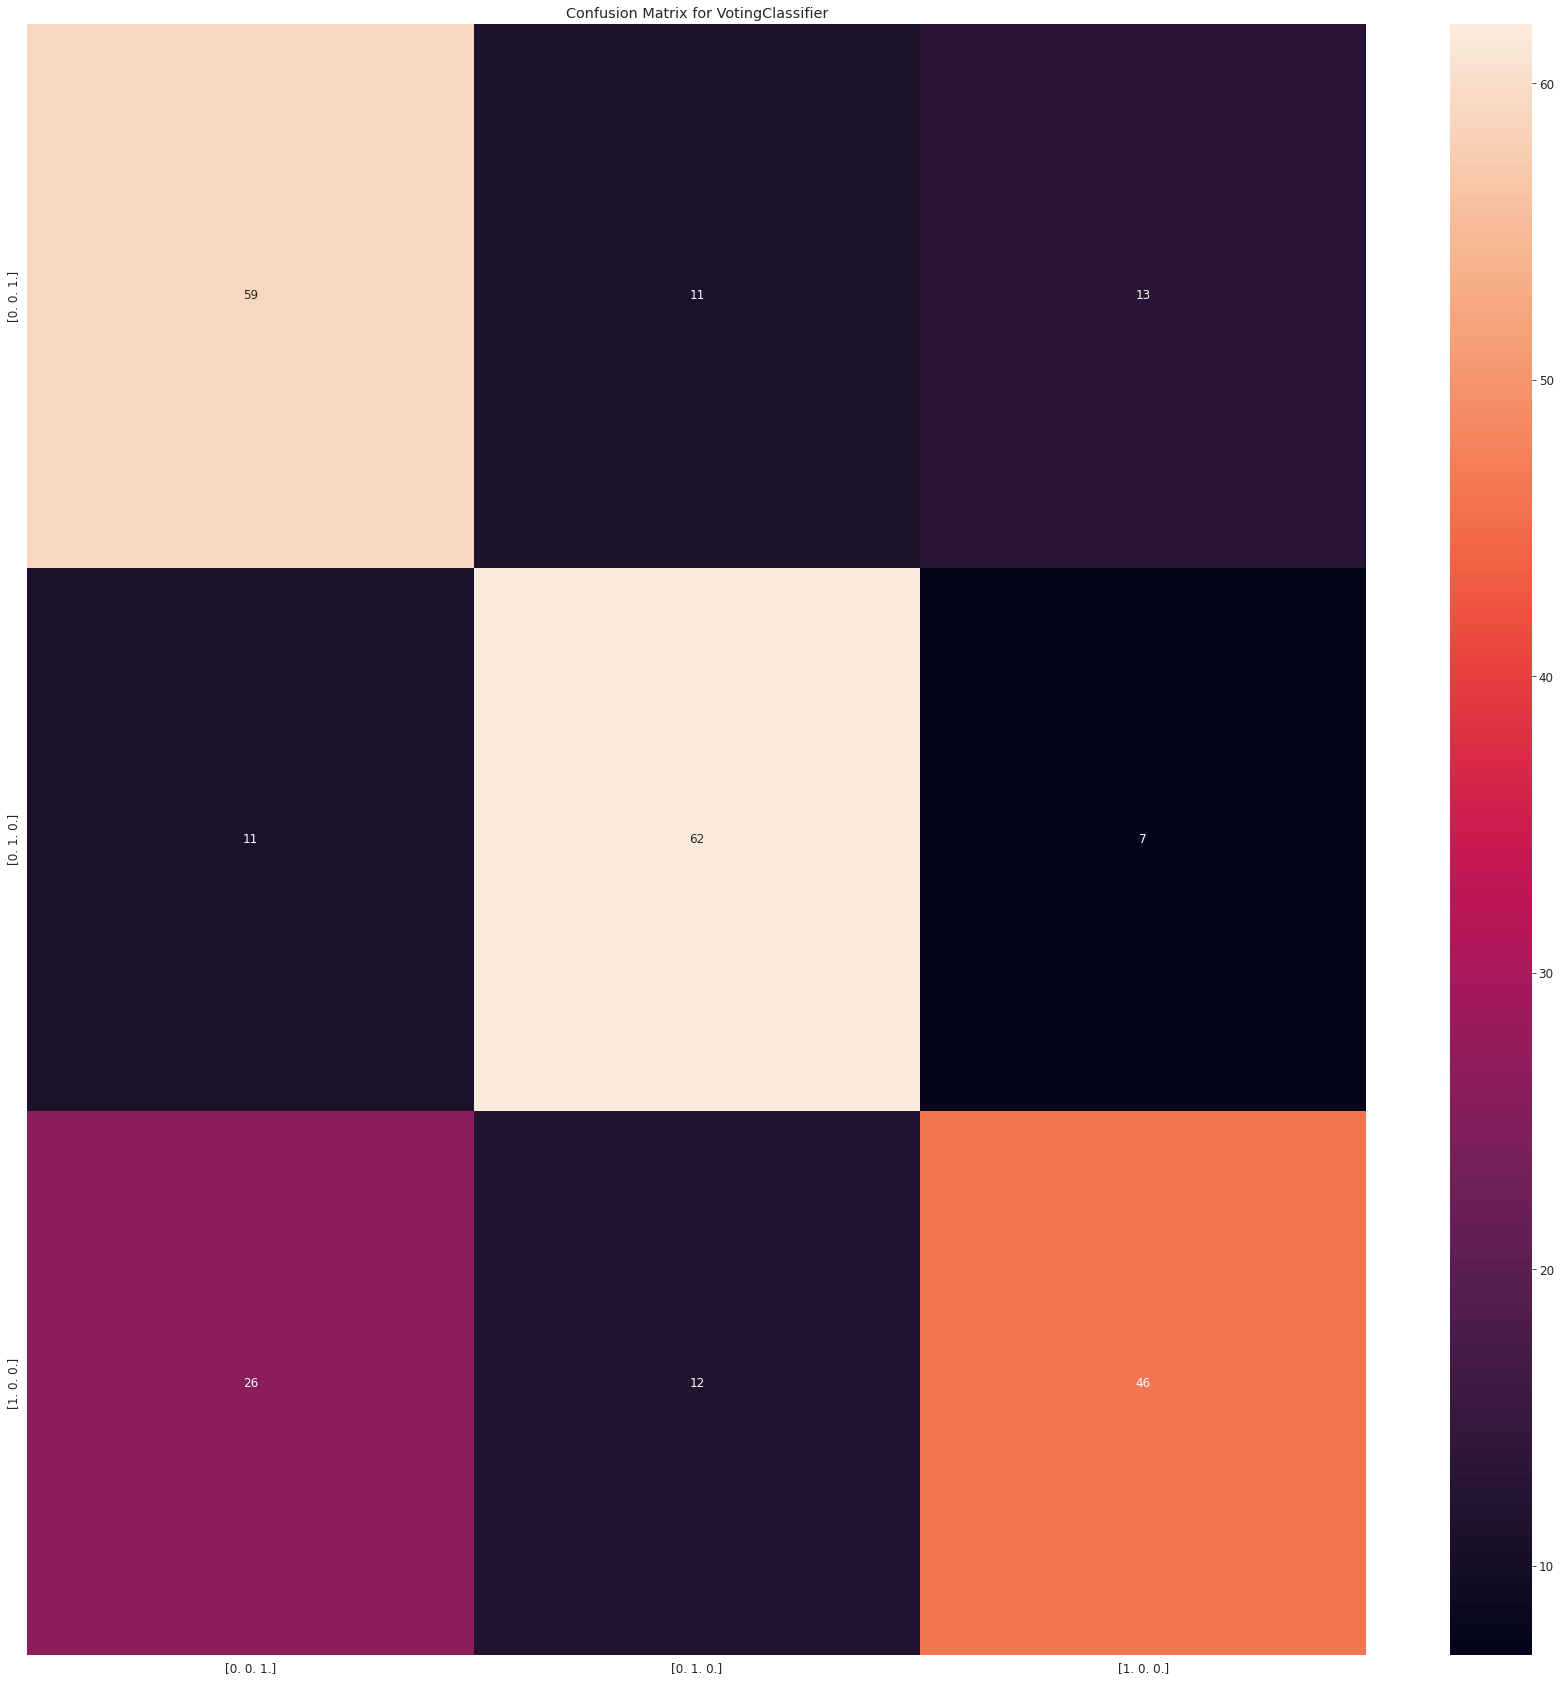

 60%|██████    | 3/5 [00:04<00:03,  1.62s/it]

AdaBoostClassifier
[0 1 2] [0 1 2]


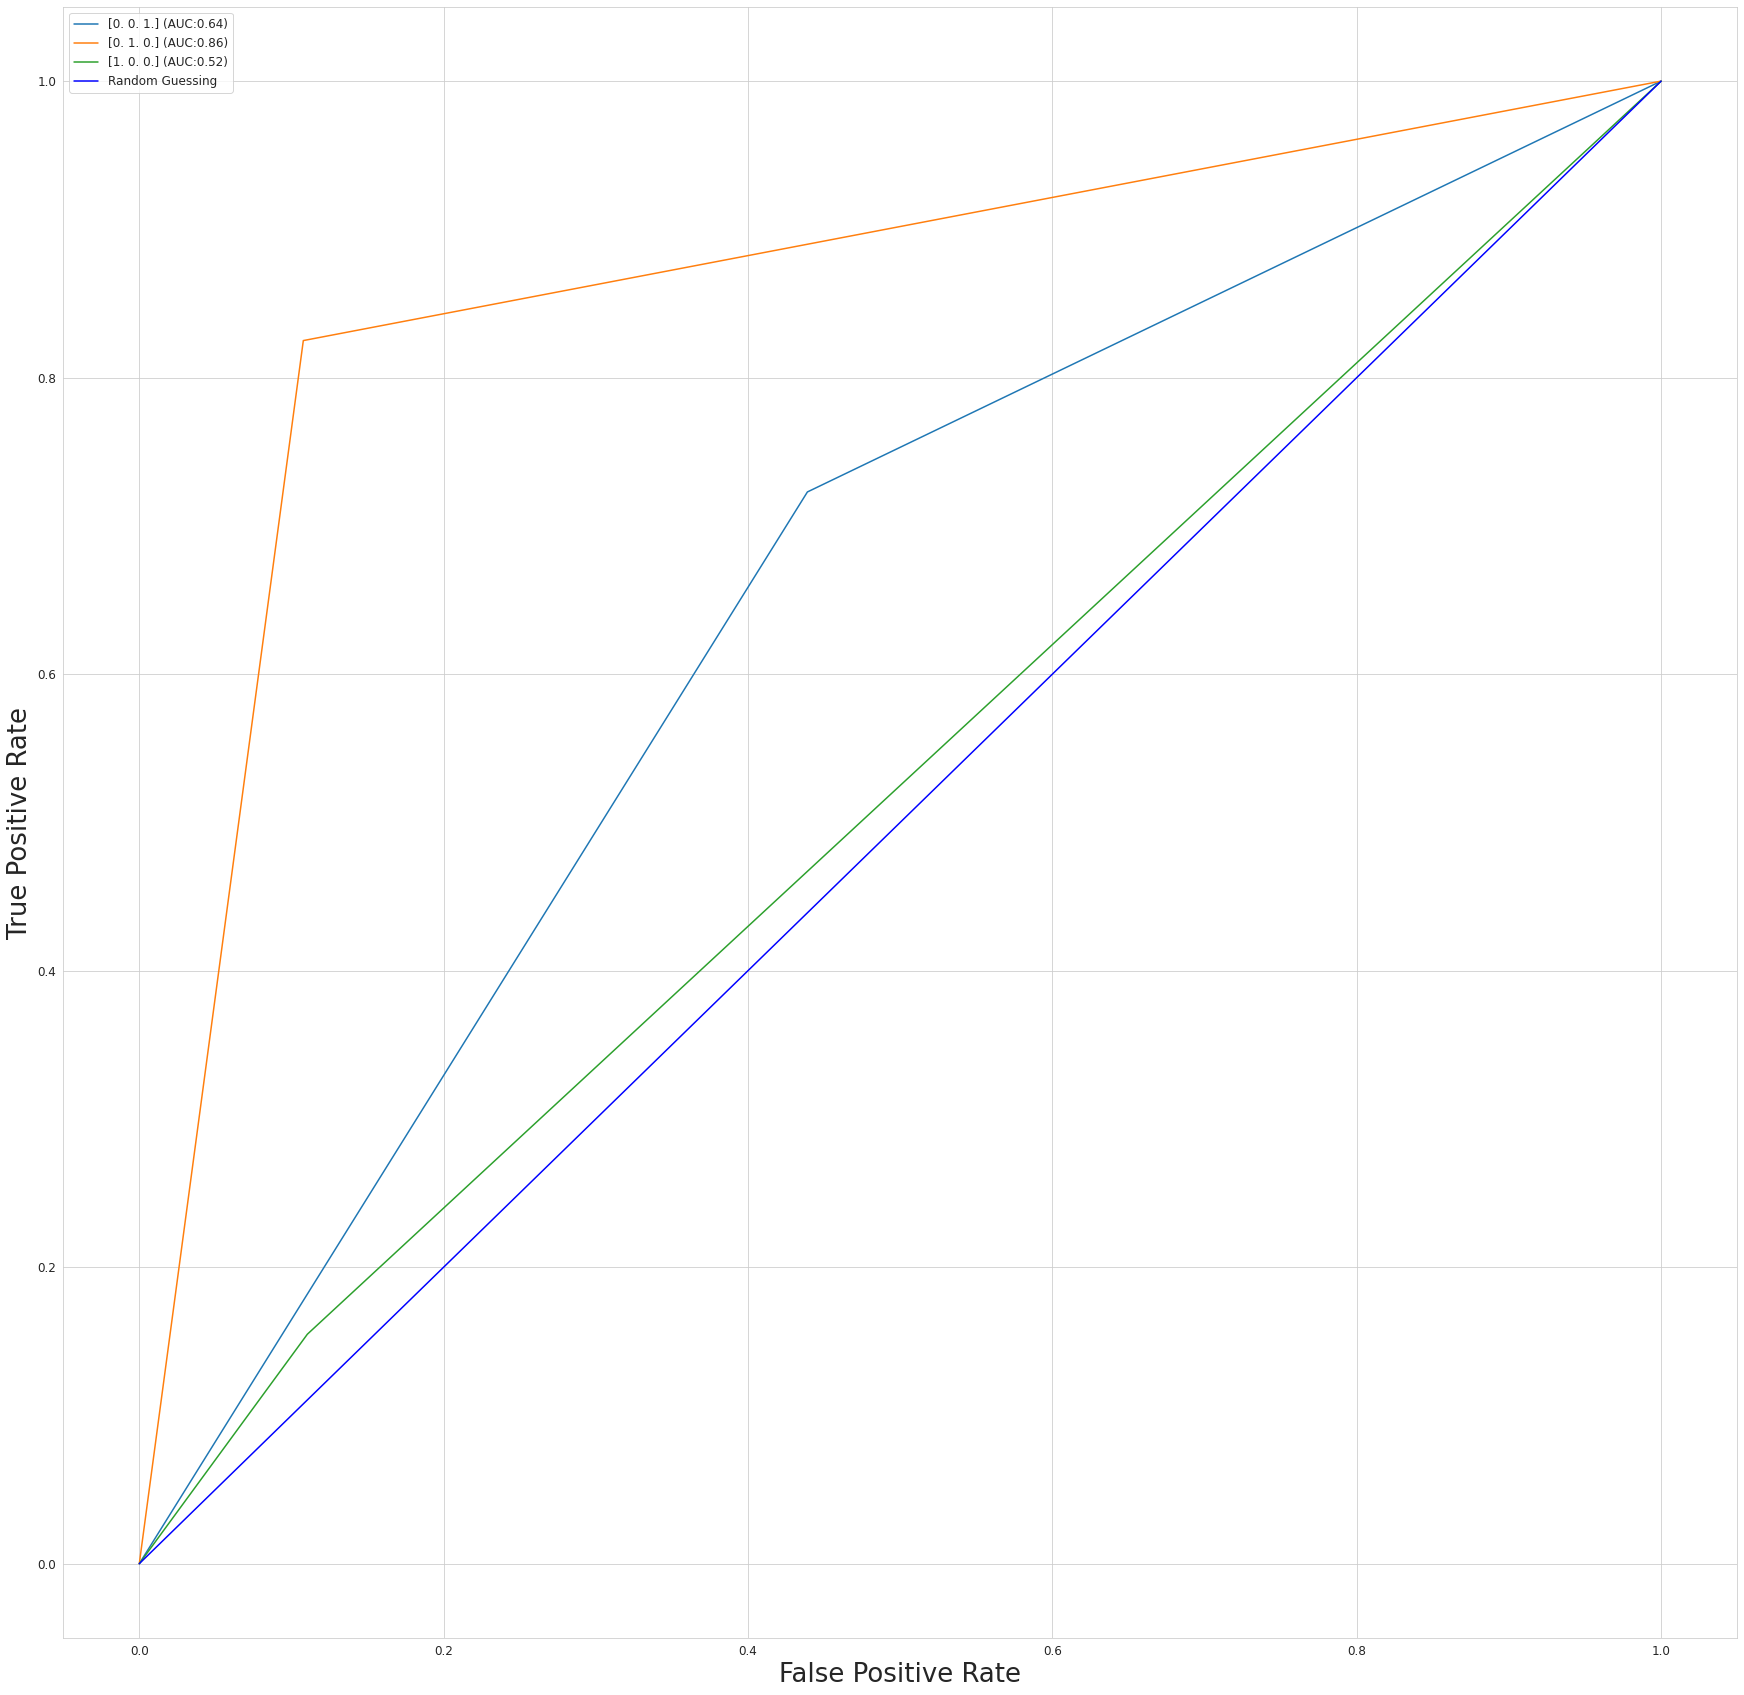

ROC AUC score: 0.6742358669654296
              precision    recall  f1-score   support

           0     0.4545    0.7229    0.5581        83
           1     0.7857    0.8250    0.8049        80
           2     0.4194    0.1548    0.2261        84

    accuracy                         0.5628       247
   macro avg     0.5532    0.5676    0.5297       247
weighted avg     0.5498    0.5628    0.5251       247




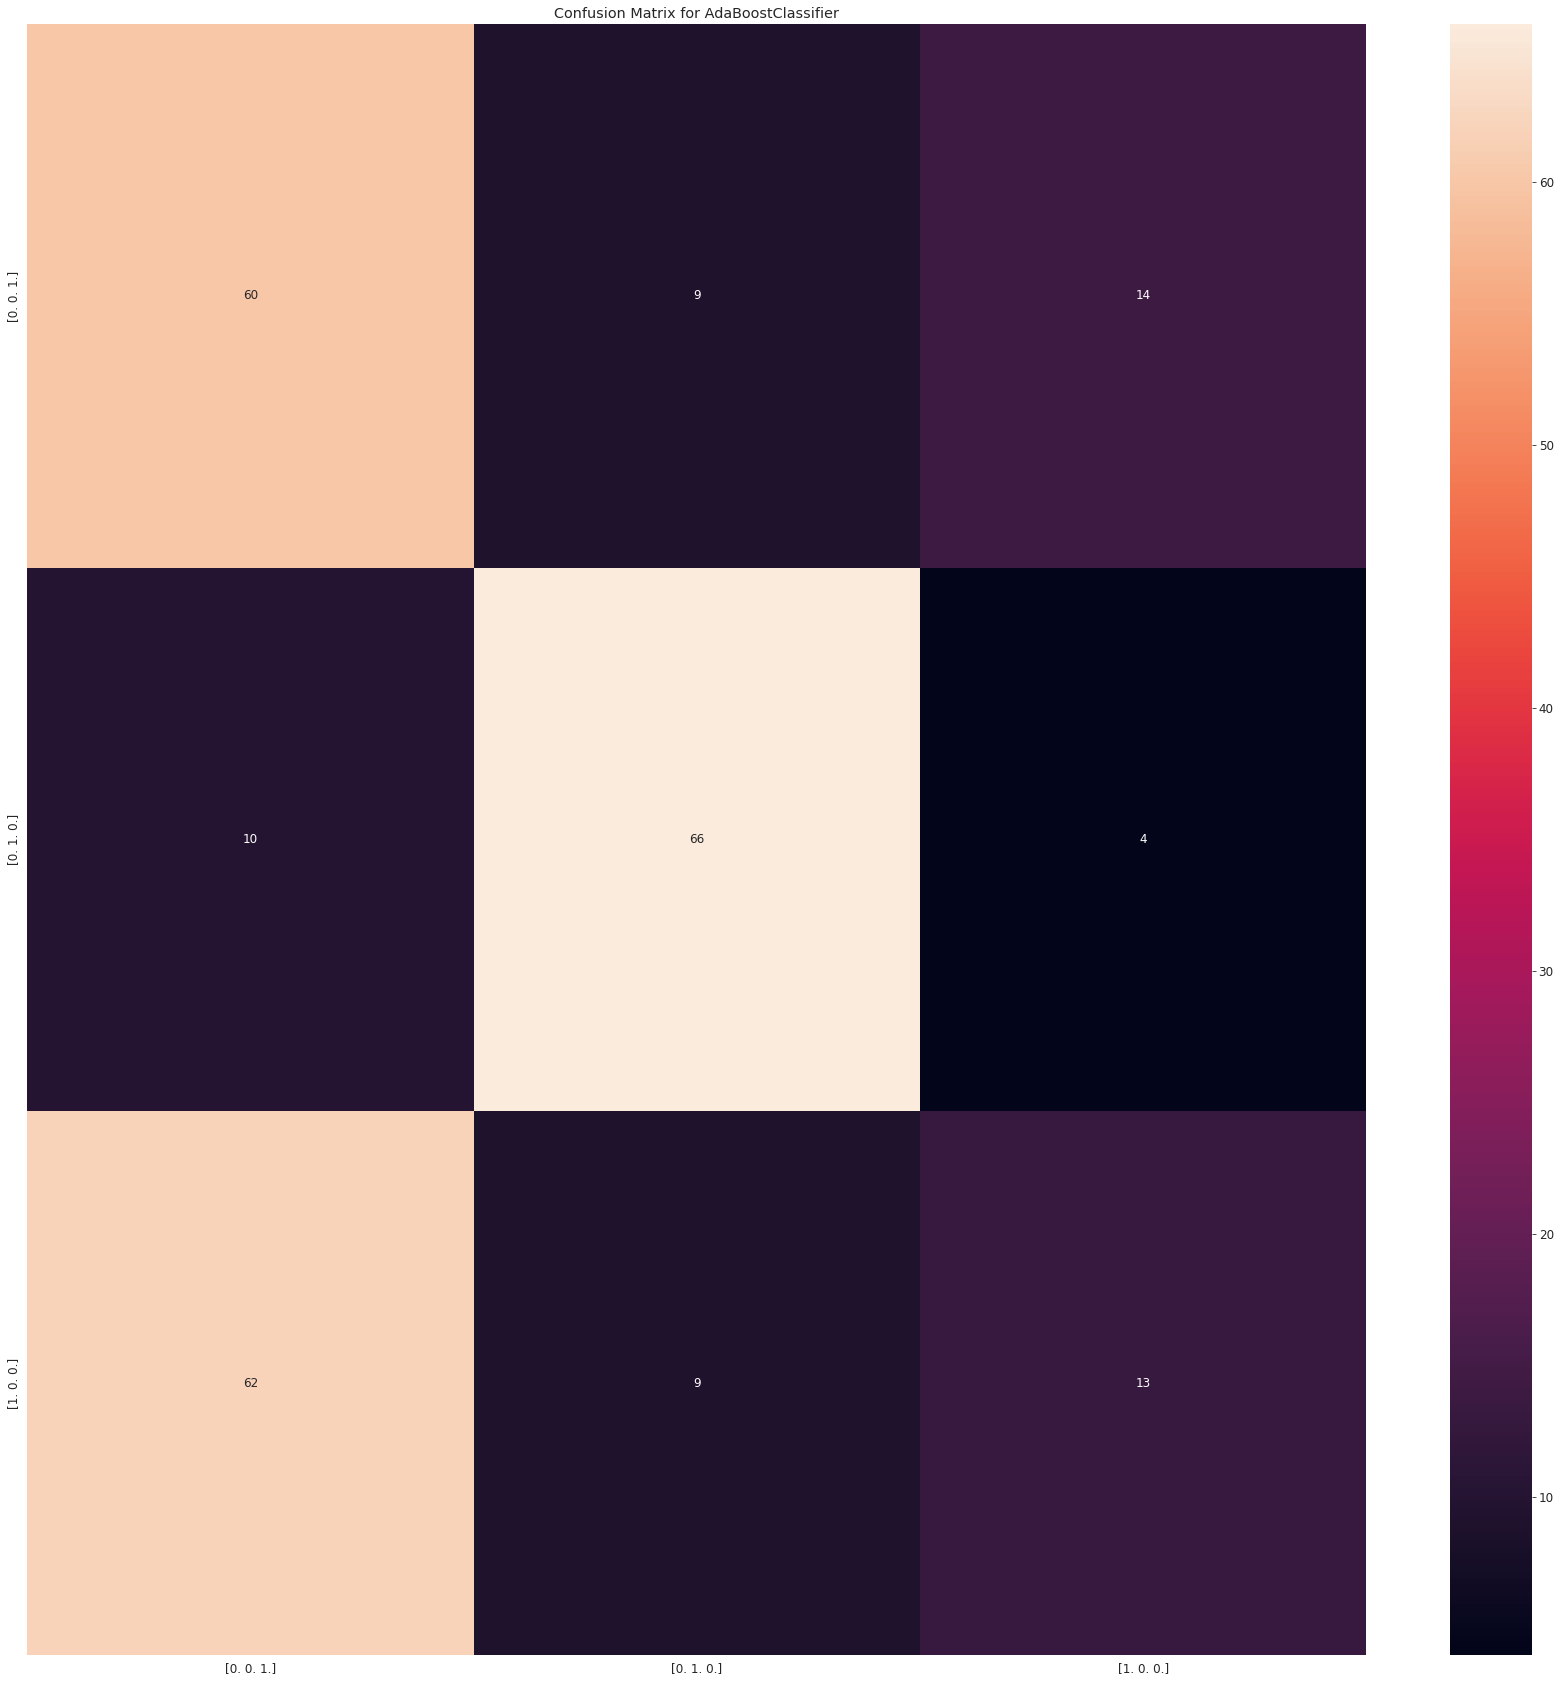

 80%|████████  | 4/5 [00:06<00:01,  1.56s/it]

XGBClassifier
[0 1 2] [0 1 2]


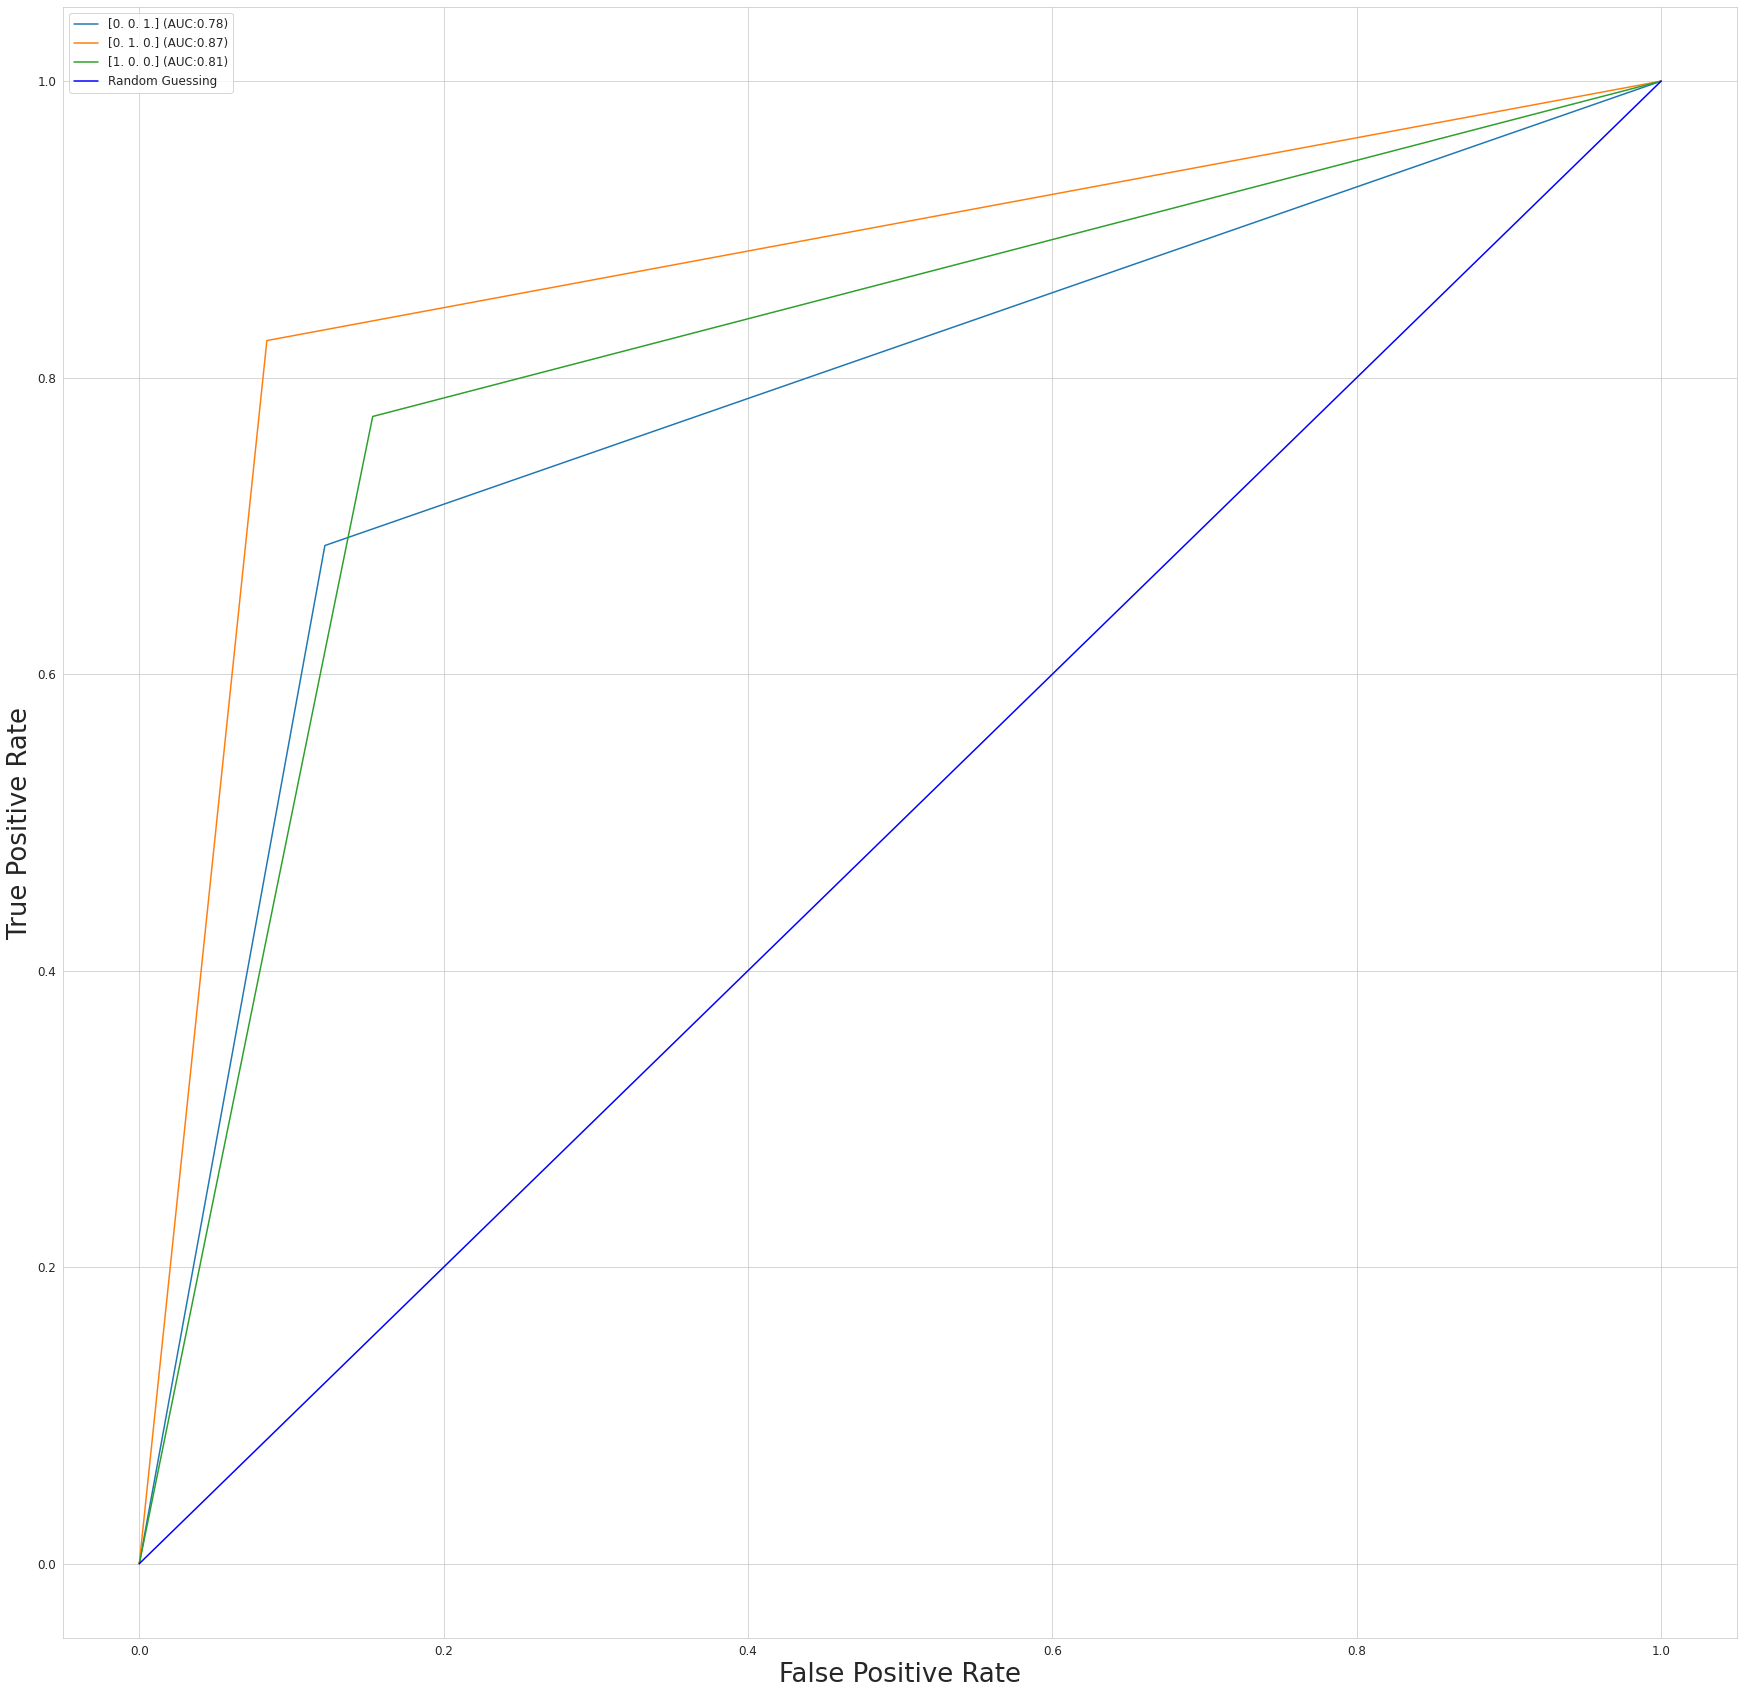

ROC AUC score: 0.8210664539651601
              precision    recall  f1-score   support

           0     0.7403    0.6867    0.7125        83
           1     0.8250    0.8250    0.8250        80
           2     0.7222    0.7738    0.7471        84

    accuracy                         0.7611       247
   macro avg     0.7625    0.7619    0.7615       247
weighted avg     0.7616    0.7611    0.7607       247




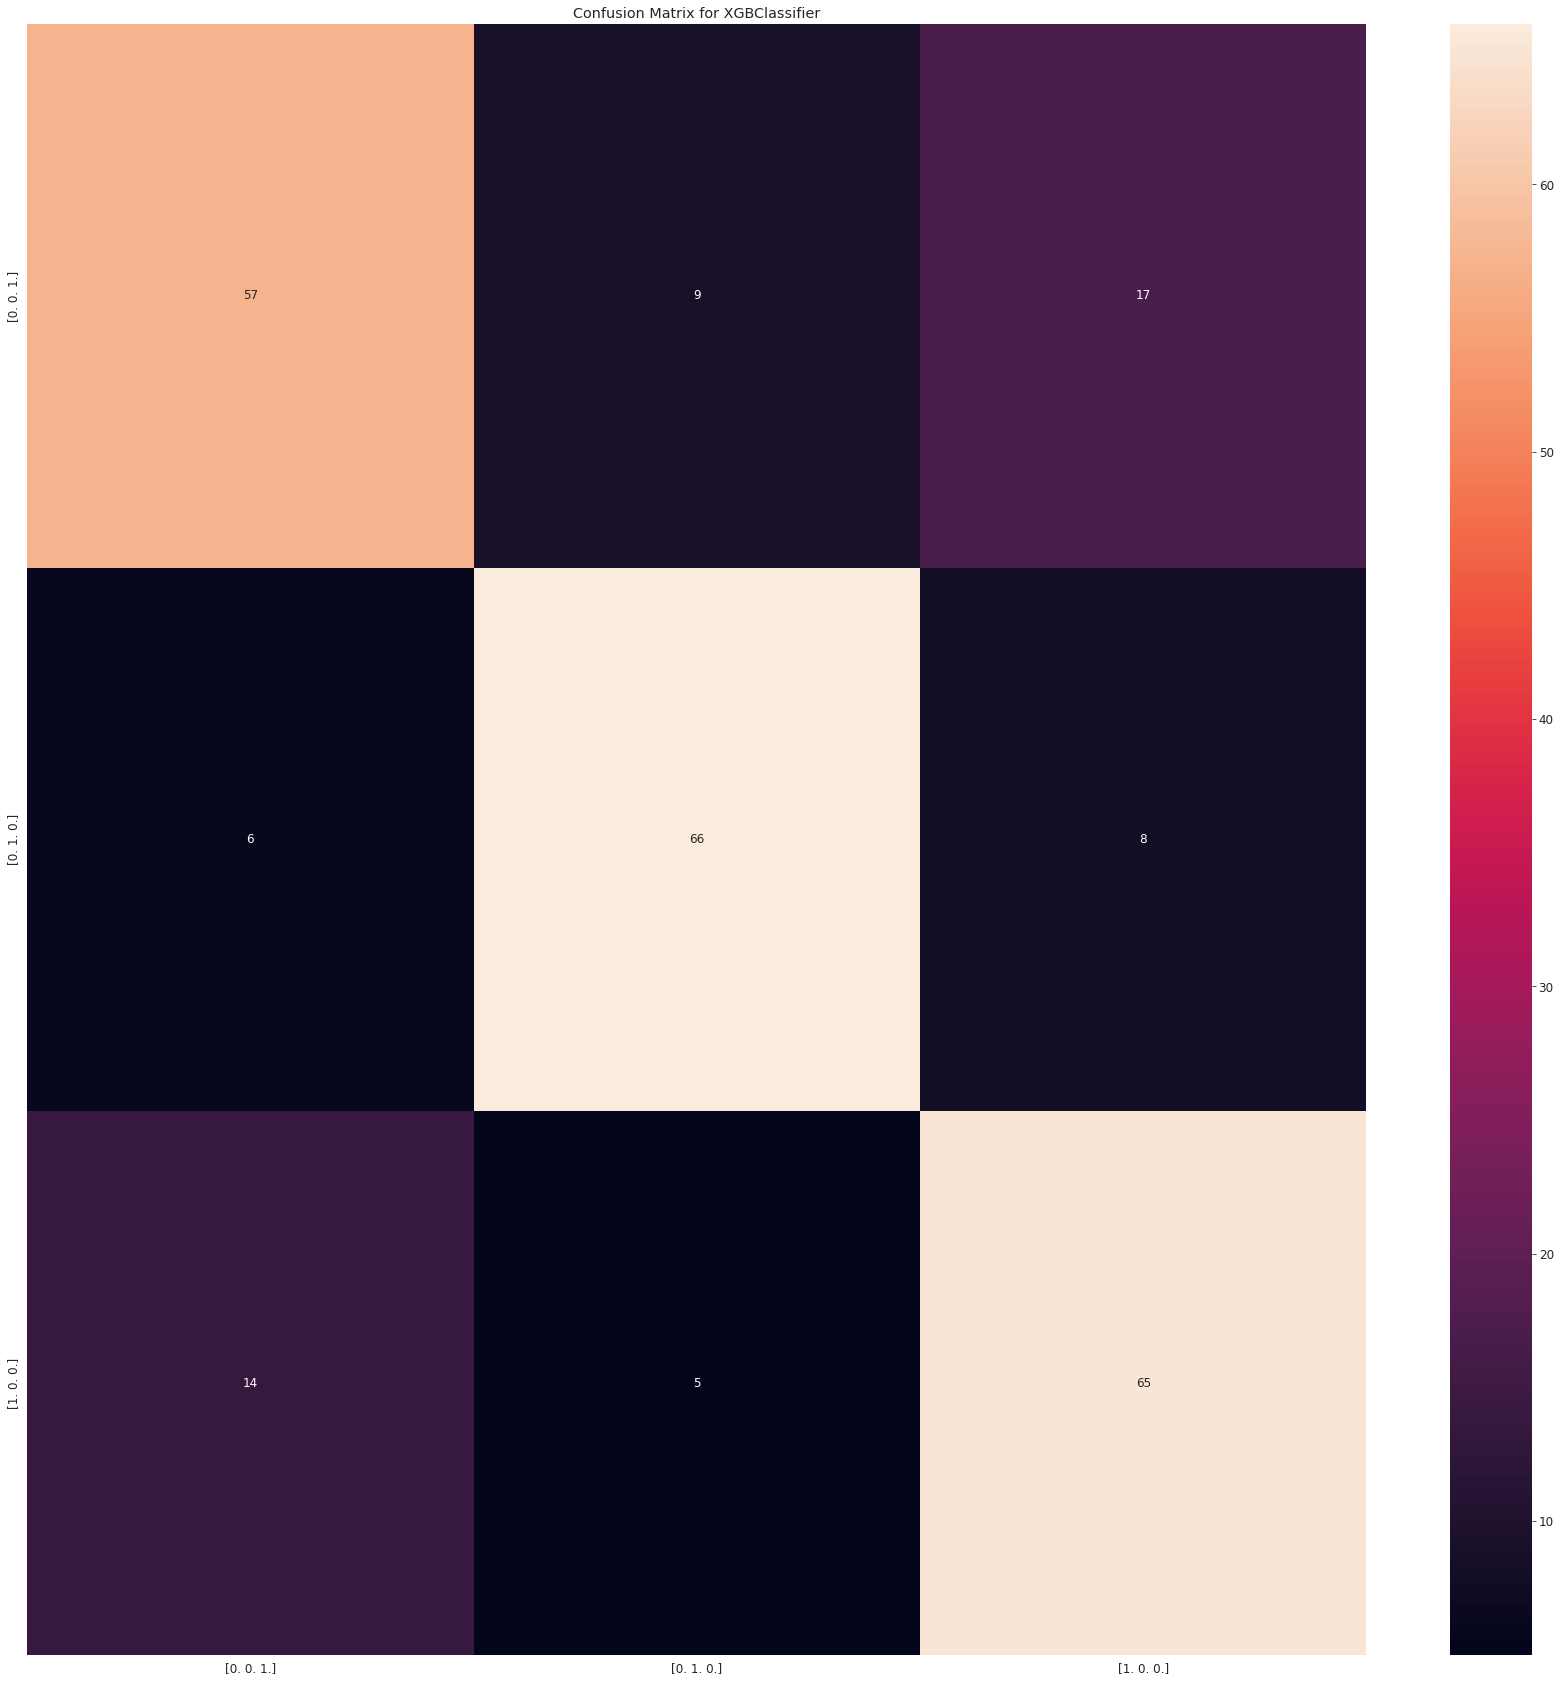

100%|██████████| 5/5 [00:09<00:00,  1.92s/it]


,Model,TN,FP,FN,TP,Accuracy,Precision,Recall or Sensitivity,F1 Score,Specificity
0,RandomForestClassifier,155.0,8.0,10.0,74.0,0.927126,0.891054,0.891141,0.891032,0.945278
1,DecisionTreeClassifier,152.0,11.0,6.0,78.0,0.927126,0.891494,0.890648,0.890674,0.945204
2,VotingClassifier,143.0,20.0,38.0,46.0,0.784076,0.680322,0.677821,0.674689,0.837989
3,AdaBoostClassifier,145.0,18.0,71.0,13.0,0.708502,0.553205,0.567551,0.529702,0.780921
4,XGBClassifier,138.0,25.0,19.0,65.0,0.840756,0.762494,0.761852,0.761542,0.880281


In [34]:

X_train, X_test, y_train, y_test = train_test_split(embeddings,yml,test_size=0.2, random_state=1) 
rdf = pd.DataFrame()
from sklearn import datasets, metrics, model_selection, svm
RNDF(X_train, y_train,embeddings,yml)

In [35]:
EPOCHS = 200
def display_training_curves(training, validation, yaxis):
    if yaxis == "loss":
        ylabel = "Loss"
        title = "Loss vs. Epochs"
    else:
        ylabel = "Accuracy"
        title = "Accuracy vs. Epochs"
        
    fig = go.Figure()
        
    fig.add_trace(
        go.Scatter(x=np.arange(1, EPOCHS+1), mode='lines+markers', y=training, marker=dict(color="dodgerblue"),
               name="Train"))
    
    fig.add_trace(
        go.Scatter(x=np.arange(1, EPOCHS+1), mode='lines+markers', y=validation, marker=dict(color="darkorange"),
               name="Val"))
    
    fig.update_layout(title_text=title, yaxis_title=ylabel, xaxis_title="Epochs", template="plotly_white")
    fig.show()

In [36]:
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import roc_curve, auc, roc_auc_score,accuracy_score,confusion_matrix
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import roc_curve, auc, roc_auc_score,accuracy_score,confusion_matrix

def onevsall(y_true,y_pred,mod):
    
    
    global rdf
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    acc = (tp+tn)/(tp+tn+fp+fn)
    pre = tp/(tp+fp)
    rec = tp/(tp+fn)
    f1 = 2*rec*pre / (rec +pre)
    sp = tn / (tn +fp)
    rdf=rdf.append({
            'Model':mod,
            'TN':tn,'FP':fp,'FN':fn,'TP':tp,
            'Accuracy':acc,
            'Precision':pre,
            'Recall or Sensitivity':rec,
            'F1 Score':f1,
            'Specificity':sp
        },ignore_index=True)
        
    return rdf

def visualise(y_true,y_pred,name,model_name):
    ConfusionM = confusion_matrix(y_true,y_pred)

    
    #print('ROC AUC score:', 
    #multiclass_roc_auc_score(y_true,y_pred, ))
    print(classification_report(y_true,y_pred,   digits=4))
    print()
    fig, ax = plt.subplots(figsize=(6,4)) 
    import seaborn as sns
    sns.heatmap(ConfusionM, annot=True,
            fmt='g',xticklabels=name, yticklabels=name)
    plt.title('Confusion Matrix for '+model_name)
    plt.savefig('CM.jpg')
    plt.show()
    

In [37]:
def view_score(score):
    for i in range(len(score)):
        print(model.metrics_names[i]+" : "+str(score[i]))
    print('--------------------------------------')
    
def metric_calc(model):
    METRICS = [
                    'accuracy',
                    tf.keras.metrics.BinaryAccuracy(),
                    tf.keras.metrics.Precision(),
                    tf.keras.metrics.Recall(),
                    tf.keras.metrics.FalseNegatives(),
                    tf.keras.metrics.FalsePositives(),
                    tf.keras.metrics.TrueNegatives(),
                    tf.keras.metrics.TruePositives(),
                    tf.keras.metrics.AUC()

            ]  
    model.compile(
                    optimizer='Adam',
                    loss='categorical_crossentropy',
                    metrics=METRICS
                )
    score = model.evaluate(X_train,y_train, verbose=0)
    view_score(score)
    score = model.evaluate(X_test, y_test, verbose=0)
    view_score(score)
    
    from sklearn.metrics import accuracy_score
    from sklearn.metrics import classification_report
    import pandas as pd
    yhat = model.predict(X_test)
    yhat = enc.inverse_transform(yhat)
    report = classification_report(enc.inverse_transform(y_test), yhat,output_dict=True,target_names=['Pos','Neg','Nue'])
    df = pd.DataFrame(report).transpose()
    
    rdf = pd.DataFrame()
    name = ['Pos','Neg', 'Neu']
    visualise(enc.inverse_transform(y_test),yhat,name,'Wavenet model')
    
    return df

# ANN

In [38]:
import tensorflow as tf
tf.config.run_functions_eagerly(True)
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import *
from tensorflow.keras.layers import Flatten , Conv1D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D,MaxPooling1D
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import UpSampling2D
def model_b():
    inp1 = Input(shape=(X_train.shape[1],),name="Wave 2 Vec DNN")
    i1 = Dense(1024, activation='relu')(inp1)
    i1 = Dense(256, activation='relu')(i1)
    i1 = Dense(64, activation='relu')(i1)
    output = Dense(3, activation='sigmoid')(i1)
    model = Model(inputs=inp1, outputs=output)
    return model
md = model_b()
md.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Wave 2 Vec DNN (InputLayer)  [(None, 512)]             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              525312    
_________________________________________________________________
dense_1 (Dense)              (None, 256)               262400    
_________________________________________________________________
dense_2 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 195       
Total params: 804,355
Trainable params: 804,355
Non-trainable params: 0
_________________________________________________________________


In [39]:
X_train, X_test, y_train, y_test = train_test_split(embeddings,y,test_size=0.2, random_state=1) 

In [40]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf
def LR_verify():
        model = model_b()
        METRICS = [
               'categorical_accuracy'
        ]  
        model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
                filepath='./',
                save_weights_only=True,
                monitor='recall',
                mode='max',
                save_best_only=True)
        model.compile(
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                loss='categorical_crossentropy',
                metrics=METRICS
            )
        history = model.fit(embeddings, y,
                            epochs=EPOCHS,
                            verbose=1,
                            shuffle = True,
                            validation_data=(X_test,y_test),
                           callbacks=[model_checkpoint_callback])
        return model,history
model,history= LR_verify()

Epoch 1/200
8/8 [==============================] - 1s 22ms/step - loss: 1.0961 - categorical_accuracy: 0.3887 - val_loss: 1.0882 - val_categorical_accuracy: 0.5600
Epoch 2/200
8/8 [==============================] - 0s 18ms/step - loss: 1.0847 - categorical_accuracy: 0.5425 - val_loss: 1.0796 - val_categorical_accuracy: 0.5600
Epoch 3/200
8/8 [==============================] - 0s 18ms/step - loss: 1.0735 - categorical_accuracy: 0.5466 - val_loss: 1.0708 - val_categorical_accuracy: 0.5800
Epoch 4/200
8/8 [==============================] - 0s 18ms/step - loss: 1.0632 - categorical_accuracy: 0.5587 - val_loss: 1.0605 - val_categorical_accuracy: 0.6000
Epoch 5/200
8/8 [==============================] - 0s 18ms/step - loss: 1.0504 - categorical_accuracy: 0.5870 - val_loss: 1.0499 - val_categorical_accuracy: 0.5600
Epoch 6/200
8/8 [==============================] - 0s 18ms/step - loss: 1.0375 - categorical_accuracy: 0.5911 - val_loss: 1.0414 - val_categorical_accuracy: 0.5800
Epoch 7/200
8/8 

In [41]:
import plotly.graph_objects as go
display_training_curves(
    history.history['categorical_accuracy'], 
    history.history['val_categorical_accuracy'], 
    'accuracy')

In [42]:
display_training_curves(
    history.history['loss'], 
    history.history['val_loss'], 
    'accuracy')

In [43]:
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
acc_df = pd.DataFrame(np.transpose([[*np.arange(1, EPOCHS+1).tolist()*3], ["Train"]*EPOCHS + ["Val"]*EPOCHS + ["Benchmark"]*EPOCHS,
                                     history.history['categorical_accuracy'] + history.history['val_categorical_accuracy'] + [1.0]*EPOCHS]))
acc_df.columns = ["Epochs", "Stage", "Accuracy"]
acc_df['Accuracy'] = acc_df['Accuracy'].astype('float')
fig = px.bar(acc_df, x="Accuracy", y="Stage", animation_frame="Epochs", title="Accuracy vs. Epochs", color='Stage',
       color_discrete_map={"Train":"dodgerblue", "Val":"darkorange", "Benchmark":"seagreen"}, orientation="h")

fig.update_layout(
    xaxis = dict(
        autorange=False,
        range=[0, 1]
    )
)

fig.update_layout(template="plotly_white")

loss : 0.3892645239830017
accuracy : 0.8426395654678345
binary_accuracy : 0.8291032910346985
precision : 0.6904761791229248
recall : 0.8832487463951111
false_negatives : 23.0
false_positives : 78.0
true_negatives : 316.0
true_positives : 174.0
auc : 0.943363606929779
--------------------------------------
loss : 0.5092348456382751
accuracy : 0.7799999713897705
binary_accuracy : 0.7866666913032532
precision : 0.640625
recall : 0.8199999928474426
false_negatives : 9.0
false_positives : 23.0
true_negatives : 77.0
true_positives : 41.0
auc : 0.9040999412536621
--------------------------------------
              precision    recall  f1-score   support

    Negative     0.7778    0.8235    0.8000        17
     Neutral     0.7333    0.7857    0.7586        14
    Positive     0.8235    0.7368    0.7778        19

    accuracy                         0.7800        50
   macro avg     0.7782    0.7820    0.7788        50
weighted avg     0.7827    0.7800    0.7800        50




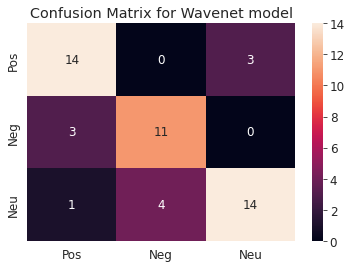

,precision,recall,f1-score,support
Pos,0.777778,0.823529,0.800000,17.00
Neg,0.733333,0.785714,0.758621,14.00
Nue,0.823529,0.736842,0.777778,19.00
accuracy,0.780000,0.780000,0.780000,0.78
macro avg,0.778214,0.782029,0.778799,50.00
weighted avg,0.782719,0.780000,0.779969,50.00


In [44]:
df = metric_calc(model)
df

In [45]:
import tensorflow as tf
tf.config.run_functions_eagerly(True)
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import *
from tensorflow.keras.layers import Flatten , Conv1D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D,MaxPooling1D
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import UpSampling2D
def model_b():
    inp1 = Input(shape=X_train.shape[1])
    i1 = Dense(2048, activation='relu')(inp1)
    i1 = Dense(1024, activation='relu')(i1)
    i1 = Dense(1024, activation='relu')(i1)
    i1 = Dense(512, activation='relu')(i1)
    i1 = Dense(512, activation='relu')(i1)
#     i1 = Reshape((50,64))(i1)
#     i1 = Bidirectional(LSTM(units=32, dropout=0.2, recurrent_dropout=0.2))(i1)
    i1 = Dense(256, activation='relu')(i1)
    i1 = Dense(64, activation='relu')(i1)
    output = Dense(3, activation='sigmoid')(i1)
    model = Model(inputs=inp1, outputs=output)
    return model
md = model_b()
md.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 512)]             0         
_________________________________________________________________
dense_8 (Dense)              (None, 2048)              1050624   
_________________________________________________________________
dense_9 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dense_10 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dense_11 (Dense)             (None, 512)               524800    
_________________________________________________________________
dense_12 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_13 (Dense)             (None, 256)               1313

# DNN

In [46]:
model,history= LR_verify()

Epoch 1/200
8/8 [==============================] - 0s 27ms/step - loss: 1.0968 - categorical_accuracy: 0.4211 - val_loss: 1.0903 - val_categorical_accuracy: 0.5800
Epoch 2/200
8/8 [==============================] - 0s 22ms/step - loss: 1.0836 - categorical_accuracy: 0.5506 - val_loss: 1.0735 - val_categorical_accuracy: 0.4800
Epoch 3/200
8/8 [==============================] - 0s 23ms/step - loss: 1.0629 - categorical_accuracy: 0.5385 - val_loss: 1.0565 - val_categorical_accuracy: 0.5400
Epoch 4/200
8/8 [==============================] - 0s 22ms/step - loss: 1.0278 - categorical_accuracy: 0.5263 - val_loss: 1.0118 - val_categorical_accuracy: 0.5800
Epoch 5/200
8/8 [==============================] - 0s 23ms/step - loss: 0.9702 - categorical_accuracy: 0.5304 - val_loss: 0.9724 - val_categorical_accuracy: 0.6000
Epoch 6/200
8/8 [==============================] - 0s 22ms/step - loss: 0.9257 - categorical_accuracy: 0.5587 - val_loss: 0.9725 - val_categorical_accuracy: 0.4400
Epoch 7/200
8/8 

In [47]:
display_training_curves(
    history.history['categorical_accuracy'], 
    history.history['val_categorical_accuracy'], 
    'accuracy')

In [48]:
display_training_curves(
    history.history['loss'], 
    history.history['val_loss'], 
    'accuracy')

In [49]:
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
acc_df = pd.DataFrame(np.transpose([[*np.arange(1, EPOCHS+1).tolist()*3], ["Train"]*EPOCHS + ["Val"]*EPOCHS + ["Benchmark"]*EPOCHS,
                                     history.history['categorical_accuracy'] + history.history['val_categorical_accuracy'] + [1.0]*EPOCHS]))
acc_df.columns = ["Epochs", "Stage", "Accuracy"]
acc_df['Accuracy'] = acc_df['Accuracy'].astype('float')
fig = px.bar(acc_df, x="Accuracy", y="Stage", animation_frame="Epochs", title="Accuracy vs. Epochs", color='Stage',
       color_discrete_map={"Train":"dodgerblue", "Val":"darkorange", "Benchmark":"seagreen"}, orientation="h")

fig.update_layout(
    xaxis = dict(
        autorange=False,
        range=[0, 1]
    )
)

fig.update_layout(template="plotly_white")

loss : 0.11897969990968704
accuracy : 0.9492385983467102
binary_accuracy : 0.9103214740753174
precision_1 : 0.7879999876022339
recall_1 : 1.0
false_negatives_1 : 0.0
false_positives_1 : 53.0
true_negatives_1 : 341.0
true_positives_1 : 197.0
auc_1 : 0.9929913878440857
--------------------------------------
loss : 0.1635417938232422
accuracy : 0.9399999976158142
binary_accuracy : 0.8866667151451111
precision_1 : 0.7538461685180664
recall_1 : 0.9800000190734863
false_negatives_1 : 1.0
false_positives_1 : 16.0
true_negatives_1 : 84.0
true_positives_1 : 49.0
auc_1 : 0.9860000610351562
--------------------------------------
              precision    recall  f1-score   support

    Negative     0.9412    0.9412    0.9412        17
     Neutral     0.8750    1.0000    0.9333        14
    Positive     1.0000    0.8947    0.9444        19

    accuracy                         0.9400        50
   macro avg     0.9387    0.9453    0.9397        50
weighted avg     0.9450    0.9400    0.9402     

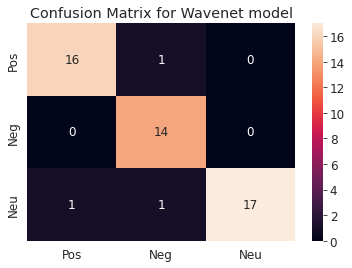

,precision,recall,f1-score,support
Pos,0.941176,0.941176,0.941176,17.00
Neg,0.875000,1.000000,0.933333,14.00
Nue,1.000000,0.894737,0.944444,19.00
accuracy,0.940000,0.940000,0.940000,0.94
macro avg,0.938725,0.945304,0.939651,50.00
weighted avg,0.945000,0.940000,0.940222,50.00


In [50]:
df = metric_calc(model)
df

# BiLSTM

In [51]:
import tensorflow as tf
tf.config.run_functions_eagerly(True)
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import *
from tensorflow.keras.layers import Flatten , Conv1D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D,MaxPooling1D
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import UpSampling2D
def model_b():
    inp1 = Input(shape=X_train.shape[1])
    i1 = Dense(2048, activation='relu')(inp1)
    i1 = Dense(1024, activation='relu')(i1)
    i1 = Dense(50*64, activation='relu')(i1)
    i1 = Reshape((50,64))(i1)
    i1 = Bidirectional(LSTM(units=32, dropout=0.2, recurrent_dropout=0.2))(i1)
    i1 = Dense(256, activation='relu')(i1)
    i1 = Dense(64, activation='relu')(i1)
    output = Dense(3, activation='sigmoid')(i1)
    model = Model(inputs=inp1, outputs=output)
    return model
md = model_b()
md.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 512)]             0         
_________________________________________________________________
dense_24 (Dense)             (None, 2048)              1050624   
_________________________________________________________________
dense_25 (Dense)             (None, 1024)              2098176   
_________________________________________________________________
dense_26 (Dense)             (None, 3200)              3280000   
_________________________________________________________________
reshape (Reshape)            (None, 50, 64)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                24832     
_________________________________________________________________
dense_27 (Dense)             (None, 256)               1664

In [52]:
model,history= LR_verify()

Epoch 1/200
8/8 [==============================] - 7s 861ms/step - loss: 1.0988 - categorical_accuracy: 0.3198 - val_loss: 1.0976 - val_categorical_accuracy: 0.3400
Epoch 2/200
8/8 [==============================] - 6s 784ms/step - loss: 1.0969 - categorical_accuracy: 0.4130 - val_loss: 1.0956 - val_categorical_accuracy: 0.4400
Epoch 3/200
8/8 [==============================] - 7s 831ms/step - loss: 1.0937 - categorical_accuracy: 0.4899 - val_loss: 1.0915 - val_categorical_accuracy: 0.4800
Epoch 4/200
8/8 [==============================] - 7s 832ms/step - loss: 1.0882 - categorical_accuracy: 0.4656 - val_loss: 1.0844 - val_categorical_accuracy: 0.4800
Epoch 5/200
8/8 [==============================] - 6s 781ms/step - loss: 1.0788 - categorical_accuracy: 0.5101 - val_loss: 1.0702 - val_categorical_accuracy: 0.4800
Epoch 6/200
8/8 [==============================] - 7s 804ms/step - loss: 1.0560 - categorical_accuracy: 0.5020 - val_loss: 1.0489 - val_categorical_accuracy: 0.4800
Epoch 7/20

In [53]:
display_training_curves(
    history.history['loss'], 
    history.history['val_loss'], 
    'accuracy')

In [54]:
display_training_curves(
    history.history['categorical_accuracy'], 
    history.history['val_categorical_accuracy'], 
    'accuracy')

In [55]:
acc_df = pd.DataFrame(np.transpose([[*np.arange(1, EPOCHS+1).tolist()*3], ["Train"]*EPOCHS + ["Val"]*EPOCHS + ["Benchmark"]*EPOCHS,
                                     history.history['categorical_accuracy'] + history.history['val_categorical_accuracy'] + [1.0]*EPOCHS]))
acc_df.columns = ["Epochs", "Stage", "Accuracy"]
acc_df['Accuracy'] = acc_df['Accuracy'].astype('float')
fig = px.bar(acc_df, x="Accuracy", y="Stage", animation_frame="Epochs", title="Accuracy vs. Epochs", color='Stage',
       color_discrete_map={"Train":"dodgerblue", "Val":"darkorange", "Benchmark":"seagreen"}, orientation="h")

fig.update_layout(
    xaxis = dict(
        autorange=False,
        range=[0, 1]
    )
)

fig.update_layout(template="plotly_white")

loss : 0.18764372169971466
accuracy : 0.9289340376853943
binary_accuracy : 0.8663282990455627
precision_2 : 0.7185184955596924
recall_2 : 0.9847715497016907
false_negatives_2 : 3.0
false_positives_2 : 76.0
true_negatives_2 : 318.0
true_positives_2 : 194.0
auc_2 : 0.9732987284660339
--------------------------------------
loss : 0.23731784522533417
accuracy : 0.8999999761581421
binary_accuracy : 0.8199999928474426
precision_2 : 0.6575342416763306
recall_2 : 0.9599999785423279
false_negatives_2 : 2.0
false_positives_2 : 25.0
true_negatives_2 : 75.0
true_positives_2 : 48.0
auc_2 : 0.9575999975204468
--------------------------------------
              precision    recall  f1-score   support

    Negative     0.9375    0.8824    0.9091        17
     Neutral     0.9286    0.9286    0.9286        14
    Positive     0.8500    0.8947    0.8718        19

    accuracy                         0.9000        50
   macro avg     0.9054    0.9019    0.9032        50
weighted avg     0.9017    0.900

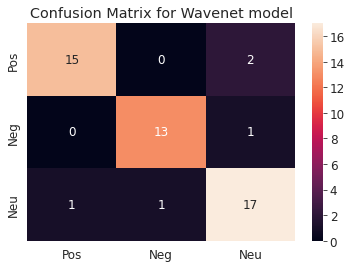

,precision,recall,f1-score,support
Pos,0.937500,0.882353,0.909091,17.0
Neg,0.928571,0.928571,0.928571,14.0
Nue,0.850000,0.894737,0.871795,19.0
accuracy,0.900000,0.900000,0.900000,0.9
macro avg,0.905357,0.901887,0.903152,50.0
weighted avg,0.901750,0.900000,0.900373,50.0


In [56]:
df = metric_calc(model)
df

# CNN

In [57]:
import tensorflow as tf
tf.config.run_functions_eagerly(True)
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import *
from tensorflow.keras.layers import Flatten , Conv1D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D,MaxPooling1D
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import UpSampling2D
def model_b():
    inp1 = Input(shape=X_train.shape[1])
    i1 = Dense(2048, activation='relu')(inp1)
    i1 = Dense(1024, activation='relu')(i1)
    i1 = Dense(50*64, activation='relu')(i1)
    i1 = Reshape((50,64))(i1)
    i1 = tf.keras.layers.Conv1D(32, 3, activation='relu')(i1)
    i1 = Flatten()(i1)
    i1 = Dense(256, activation='relu')(i1)
    i1 = Dense(64, activation='relu')(i1)
    output = Dense(3, activation='sigmoid')(i1)
    model = Model(inputs=inp1, outputs=output)
    return model
md = model_b()
md.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 512)]             0         
_________________________________________________________________
dense_36 (Dense)             (None, 2048)              1050624   
_________________________________________________________________
dense_37 (Dense)             (None, 1024)              2098176   
_________________________________________________________________
dense_38 (Dense)             (None, 3200)              3280000   
_________________________________________________________________
reshape_2 (Reshape)          (None, 50, 64)            0         
_________________________________________________________________
conv1d (Conv1D)              (None, 48, 32)            6176      
_________________________________________________________________
flatten (Flatten)            (None, 1536)              0   

In [58]:
model,history= LR_verify()

Epoch 1/200
8/8 [==============================] - 6s 31ms/step - loss: 1.0941 - categorical_accuracy: 0.4494 - val_loss: 1.0848 - val_categorical_accuracy: 0.4600
Epoch 2/200
8/8 [==============================] - 0s 26ms/step - loss: 1.0762 - categorical_accuracy: 0.4615 - val_loss: 1.0622 - val_categorical_accuracy: 0.4800
Epoch 3/200
8/8 [==============================] - 0s 24ms/step - loss: 1.0498 - categorical_accuracy: 0.5101 - val_loss: 1.0387 - val_categorical_accuracy: 0.5000
Epoch 4/200
8/8 [==============================] - 0s 25ms/step - loss: 1.0091 - categorical_accuracy: 0.5223 - val_loss: 0.9921 - val_categorical_accuracy: 0.5000
Epoch 5/200
8/8 [==============================] - 0s 27ms/step - loss: 0.9578 - categorical_accuracy: 0.5304 - val_loss: 0.9499 - val_categorical_accuracy: 0.5200
Epoch 6/200
8/8 [==============================] - 0s 24ms/step - loss: 0.9255 - categorical_accuracy: 0.5709 - val_loss: 0.9356 - val_categorical_accuracy: 0.6200
Epoch 7/200
8/8 

In [59]:
display_training_curves(
    history.history['loss'], 
    history.history['val_loss'], 
    'accuracy')

In [60]:
display_training_curves(
    history.history['categorical_accuracy'], 
    history.history['val_categorical_accuracy'], 
    'accuracy')

In [61]:
acc_df = pd.DataFrame(np.transpose([[*np.arange(1, EPOCHS+1).tolist()*3], ["Train"]*EPOCHS + ["Val"]*EPOCHS + ["Benchmark"]*EPOCHS,
                                     history.history['categorical_accuracy'] + history.history['val_categorical_accuracy'] + [1.0]*EPOCHS]))
acc_df.columns = ["Epochs", "Stage", "Accuracy"]
acc_df['Accuracy'] = acc_df['Accuracy'].astype('float')
fig = px.bar(acc_df, x="Accuracy", y="Stage", animation_frame="Epochs", title="Accuracy vs. Epochs", color='Stage',
       color_discrete_map={"Train":"dodgerblue", "Val":"darkorange", "Benchmark":"seagreen"}, orientation="h")

fig.update_layout(
    xaxis = dict(
        autorange=False,
        range=[0, 1]
    )
)

fig.update_layout(template="plotly_white")

loss : 0.10438735783100128
accuracy : 0.9644669890403748
binary_accuracy : 0.8494077324867249
precision_3 : 0.6901408433914185
recall_3 : 0.9949238300323486
false_negatives_3 : 1.0
false_positives_3 : 88.0
true_negatives_3 : 306.0
true_positives_3 : 196.0
auc_3 : 0.989847719669342
--------------------------------------
loss : 0.12593023478984833
accuracy : 0.9599999785423279
binary_accuracy : 0.8066667318344116
precision_3 : 0.6329113841056824
recall_3 : 1.0
false_negatives_3 : 0.0
false_positives_3 : 29.0
true_negatives_3 : 71.0
true_positives_3 : 50.0
auc_3 : 0.9815000295639038
--------------------------------------
              precision    recall  f1-score   support

    Negative     0.8947    1.0000    0.9444        17
     Neutral     1.0000    1.0000    1.0000        14
    Positive     1.0000    0.8947    0.9444        19

    accuracy                         0.9600        50
   macro avg     0.9649    0.9649    0.9630        50
weighted avg     0.9642    0.9600    0.9600     

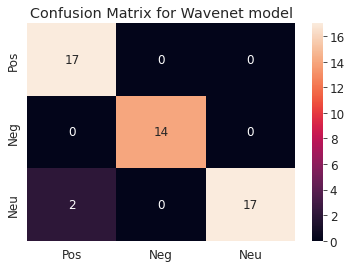

,precision,recall,f1-score,support
Pos,0.894737,1.000000,0.944444,17.00
Neg,1.000000,1.000000,1.000000,14.00
Nue,1.000000,0.894737,0.944444,19.00
accuracy,0.960000,0.960000,0.960000,0.96
macro avg,0.964912,0.964912,0.962963,50.00
weighted avg,0.964211,0.960000,0.960000,50.00


In [62]:
df = metric_calc(model)
df

In [63]:
!zip -r OP_ID_BC.zip ./

  adding: .virtual_documents/ (stored 0%)
  adding: MLclasses.npy (deflated 89%)
  adding: AUDIO_MetaData.csv (deflated 71%)
  adding: ROC_AUC__XGBClassifier.jpeg (deflated 62%)
  adding: AdaBoostClassifier.csv (deflated 41%)
  adding: CM.jpg (deflated 21%)
  adding: CM_VotingClassifier.jpg (deflated 79%)
  adding: CM_DecisionTreeClassifier.jpg (deflated 79%)
  adding: Wave2VecEmbedding.npy (deflated 9%)
  adding: ROC_AUC__VotingClassifier.jpeg (deflated 61%)
  adding: VotingClassifier.csv (deflated 41%)
  adding: CM_AdaBoostClassifier.jpg (deflated 79%)
  adding: RandomForestClassifier.csv (deflated 41%)
  adding: ROC_AUC__RandomForestClassifier.jpeg (deflated 64%)
  adding: DecisionTreeClassifier.csv (deflated 40%)
  adding: CM_XGBClassifier.jpg (deflated 80%)
  adding: CM_RandomForestClassifier.jpg (deflated 79%)
  adding: audio_df.pickle (deflated 15%)
  adding: XGBClassifier.csv (deflated 41%)
  adding: ROC_AUC__AdaBoostClassifier.jpeg (deflated 61%)
  adding: y.npy (deflated 95%)

In [64]:
from IPython.display import FileLink, FileLinks
FileLinks('.')

./
  MLclasses.npy
  AUDIO_MetaData.csv
  ROC_AUC__XGBClassifier.jpeg
  AdaBoostClassifier.csv
  CM.jpg
  CM_VotingClassifier.jpg
  CM_DecisionTreeClassifier.jpg
  OP_ID_BC.zip
  Wave2VecEmbedding.npy
  ROC_AUC__VotingClassifier.jpeg
  VotingClassifier.csv
  CM_AdaBoostClassifier.jpg
  RandomForestClassifier.csv
  ROC_AUC__RandomForestClassifier.jpeg
  DecisionTreeClassifier.csv
  CM_XGBClassifier.jpg
  CM_RandomForestClassifier.jpg
  audio_df.pickle
  XGBClassifier.csv
  ROC_AUC__AdaBoostClassifier.jpeg
  y.npy
  ROC_AUC__DecisionTreeClassifier.jpeg